# Fit Thermo Groups From Thermo Library

This script takes in user-specified thermo libraries and automatically identifies missing groups, generates group structures, and calculates missing group values using Ridge regression with one-fold cross-validation for hyperparameter tuning. It identifies missing group by checking if the node data is `None`, all zeros, or a string.

This script generates a `group.py` file and replaces the old one.

In [27]:
from rmgpy import settings
from rmgpy.data.thermo import ThermoDatabase, ThermoData, remove_thermo_data, add_thermo_data
import rmgpy.molecule.group as gr
from rmgpy.molecule.group import Group, GroupAtom, GroupBond
from rmgpy.data.base import Entry
from rmgpy.data.base import LogicOr
from rmgpy.molecule.atomtype import ATOMTYPES

import logging
import os
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from copy import copy, deepcopy
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("seaborn-poster")
import numpy as np

from copy import deepcopy
from sklearn.linear_model import RidgeCV,LassoCV,ElasticNetCV,LinearRegression
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error

# User inputs

Input thermo libraries to fit thermo groups from.

In [28]:
libraries = ['Boron_Vuori']

# 1. Define helper functions

In [29]:
def check_data(label=None,index=None):
    """
    Helper functions for checking outlier species in the parity plot.
    User can input either the label or the index of a species.
    This function prints out
    - GAE with estimated GAV: group additivity estimation (GAE) with not exact fit node
                              (node data is string or None)
    - missing groups
    - GAE without estimated GAV: group additivity estimation with only the exact fit node
    - GAE with fitted GAV: GAE with newly fitted GAVs.
                           Calculated by directly adding the new groups to the GAE without estimated GAV value.
                           Does not descend the tree again.
    - New GAE: group additivity estimation using the new database. Descending from the new tree.
    """
    if index is None:
        index = label_index_dict[label]

    entry = all_data["entry"][index]
    display(entry.item)
    print(entry.item.smiles)
    entry_thermo = all_data["entry thermo"][index]

    print("Entry")
    print(entry.short_desc)
    print(entry.label)
    print(entry_thermo)
    print('')
    print("GAE with estimated GAV")
    print(all_data["GAE with estimated GAV"][index])
    print('')
    print("missing")
    print(all_data["missing groups"][index])
    print('')
    print('GAE without estimated GAV')
    print(all_data["GAE without estimated GAV"][index])
    print('')
    print("GAE with fitted GAV")
    print(all_data["GAE with fitted GAV"][index])
    print('')
    if "New GAE" in all_data:
        print("New GAE")
        print(all_data["New GAE"][index])

def add_thermo_data_uncertainty(thermo_data1, thermo_data2, group_additivity=True, verbose=False):
    """
    Adapted from the add_thermo_data function from `rmgpy.data.thermo`.
    Add the thermodynamic data, including the uncertainties, from `thermo_data2` to the data `thermo_data1`,
    and return `thermo_data1`.

    If `group_additivity` is True, append comments related to group additivity estimation
    If `verbose` is False, omit the comments from a "zero entry", whose H298, S298, and Cp are all 0.
    If `verbose` is True, or thermo_data2 is not a zero entry, add thermo_data2.comment to thermo_data1.comment.
    """
    if (len(thermo_data1.Tdata.value_si) != len(thermo_data2.Tdata.value_si) or
            any([T1 != T2 for T1, T2 in zip(thermo_data1.Tdata.value_si, thermo_data2.Tdata.value_si)])):
        raise ValueError('Cannot add these ThermoData objects due to their having different temperature points.')

    for i in range(thermo_data1.Tdata.value_si.shape[0]):
        thermo_data1.Cpdata.value_si[i] += thermo_data2.Cpdata.value_si[i]
        thermo_data1.Cpdata.uncertainty_si[i] += thermo_data2.Cpdata.uncertainty_si[i]
    thermo_data1.H298.value_si += thermo_data2.H298.value_si
    thermo_data1.H298.uncertainty_si += thermo_data2.H298.uncertainty_si
    thermo_data1.S298.value_si += thermo_data2.S298.value_si
    thermo_data1.S298.uncertainty_si += thermo_data2.S298.uncertainty_si

    test_zero = sum(abs(value) for value in
                    [thermo_data2.H298.value_si, thermo_data2.S298.value_si] + thermo_data2.Cpdata.value_si.tolist())
    # Used to check if all of the entries in thermo_data2 are zero

    if group_additivity:
        if verbose or test_zero != 0:
            if thermo_data1.comment:
                thermo_data1.comment += ' + {0}'.format(thermo_data2.comment)
            else:
                thermo_data1.comment = 'Thermo group additivity estimation: ' + thermo_data2.comment

    return thermo_data1

def get_neighbors(atom, group_atoms, n_degree_neighbor=1):
    """
    Get neighbors within n degree for the center atom recursively.

    Args:
        atom (Atom): the center atom
        group_atoms (dict): an empty dictionary
        n_degree_neighbor (int): If a neighbor is n bond apart from the center atom,
                                    it's defined as n degree neighbor.


    Returns:
        group_atoms (dict): a dictionary that has Atom object as key and the corresponding
                            GroupAtom object as value
    """

    if n_degree_neighbor == 1:

        for atm in atom.edges:
            if atm not in group_atoms:
                group_atoms[atm] = GroupAtom(atomtype=[atm.atomtype],
                                         radical_electrons=[atm.radical_electrons],
                                         label='')

    else:

        for atm in atom.edges:
            if atm not in group_atoms:
                group_atoms[atm] = GroupAtom(atomtype=[atm.atomtype],
                                         radical_electrons=[atm.radical_electrons],
                                         label='')
            get_neighbors(atm, group_atoms, n_degree_neighbor-1)

    return group_atoms

def make_bonds(atom, group, group_atoms, n_degree_neighbor=1):
    """
    Make bonds between the group atoms in the group object recursively, using the edges of the center atom
    Arg:
        atom (Atom): the center atom for the group
        group (Group): the group object where GroupAtoms are filled but GroupBonds are not added yet
        group_atoms (dict): a dictionary that has Atom object as key and the corresponding
                            GroupAtom object as value
        n_degree_neighbor (int): If a neighbor is n bond apart from the center atom,
                                    it's defined as n degree neighbor.
    Returns:
        group (Group): the group object with GroupBonds added
    """

    if n_degree_neighbor == 1:

        for bonded_atom, bond in atom.edges.items():
            if not group.has_bond(group_atoms[atom],group_atoms[bonded_atom]):
                group.add_bond(GroupBond(group_atoms[atom],group_atoms[bonded_atom],order=[bond.order]))
            else:
                pass

    else:

        for bonded_atom, bond in atom.edges.items():
            if not group.has_bond(group_atoms[atom],group_atoms[bonded_atom]):
                group.add_bond(GroupBond(group_atoms[atom],group_atoms[bonded_atom],order=[bond.order]))
            else:
                pass
            make_bonds(bonded_atom, group, group_atoms, n_degree_neighbor-1)

    return group

def make_group(atom, n_degree_neighbor=1):
    """
    Make a group with `atom` as the center atom and `n_degree_neighbor` degree of neighbor,
    using `get_neighbors` and `make_bonds` functions.

    Args:
        atom (Atom): the center atom for the group
        n_degree_neighbor (Int): If a neighbor is n bond apart from the center atom,
                                    it's defined as n degree neighbor.
    Returns:
        group (Group): the group containing the center atom and the n degrees of neighbor
    """

    group_atoms = {}
    bonds = []

    group_atoms = get_neighbors(atom, group_atoms, n_degree_neighbor=n_degree_neighbor)

    if atom.atomtype.label in ["O2s", "S2s", "O4tc", "Cs"]: # why are these atoms special?
        group_atoms[atom] = GroupAtom(atomtype=[atom.atomtype],
                                     radical_electrons=[atom.radical_electrons],
                                     label='*')
    else:
        group_atoms[atom] = GroupAtom(atomtype=[atom.atomtype],
                                     radical_electrons=[atom.radical_electrons],
                                     lone_pairs=[atom.lone_pairs],
                                     charge=[atom.charge],
                                     label='*')

    group = Group(atoms=list(group_atoms.values()))

    group = make_bonds(atom, group, group_atoms, n_degree_neighbor=n_degree_neighbor)

    group.update()

    return group

def make_neighbor_name(atom,n_degree_neighbor=1,exclude=[]):
    """
    Make the name for n degree of neighbor recursively
    Args:
        atom (Atom): the center atom for the group
        n_degree_neighbor (Int): If a neighbor is n bond apart from the center atom,
                                    it's defined as n degree neighbor.
        exclude (list of Atom): helper list to record atoms that have been named to avoid repetition

    Returns:
        neighbors (string): name for n degrees of neighbors
        exclude (list of Atom): helper list to record atoms that have been named to avoid repetition

    """

    if n_degree_neighbor == 1:

        names = []

        for atom2 in atom.edges.keys():

            if atom2.atomtype.label != 'H':

                if atom2 not in exclude:
                    atom_neighbor = atom2.atomtype.label
                    names.append(atom_neighbor)
                    exclude.append(atom2)

        neighbors = ''.join(sorted(names))
        neighbors += 'H' * len(['H' for atom2 in atom.edges.keys() if atom2.atomtype.label == 'H' and atom2 not in exclude])

        return neighbors, exclude


    else:

        names = []

        if atom not in exclude:
            exclude.append(atom)

        for atom2 in atom.edges.keys():

            if atom2.atomtype.label != 'H':

                atom_neighbor = ''

                if atom2 not in exclude:

                    atom_neighbor += atom2.atomtype.label
                    exclude.append(atom2)

                names.append(atom_neighbor)

        for (i,atom2) in enumerate(atom.edges.keys()):

            atom2_neighbor, exclude = make_neighbor_name(atom2, n_degree_neighbor-1,exclude=exclude)

            if atom2_neighbor:
                names.append(f"({atom2_neighbor})")

        neighbors = ''.join(sorted(names))
        neighbors += 'H' * len(['H' for atom2 in atom.edges.keys() if atom2.atomtype.label == 'H' and atom2 not in exclude])

        for atom2 in atom.edges.keys():
            if atom2 not in exclude:
                exclude.append(atom2)

        return neighbors, exclude

def make_group_name(atom,n_degree_neighbor=1):
    """
    Make the group string for a group with atom as its center atom and n degree of neighbor,
    using `make_neighbor_name`
    Args:
        atom (Atom): the center atom for the group
        n_degree_neighbor (Int): If a neighbor is n bond apart from the center atom,
                                    it's defined as n degree neighbor.

    Returns:
        group_str (string): name for the group
    """


    exclude = []
    group_str = atom.atomtype.label

    neighbors = make_neighbor_name(atom,n_degree_neighbor=n_degree_neighbor,exclude=exclude)[0]

    if atom.radical_electrons==1:
        group_str += "J"

    if neighbors:
        group_str += f'-{neighbors}'

    return group_str



## 1.1 Special groups that we should not fit

`special_list` contains groups that always appear with other groups such that these groups are not independent. For example, `O2d-CO` always appear with `CO-O2d`, and `S2d-CS` always appear with `CS-S2d`. In the past, RMG developers chose to set these groups to be zeros, so we don't generate new groups on them. This list needs to be updated when the relevant groups are changed.

In [30]:
special_list = [
    'O0sc-N5dc',
    'S2d-CS',
    'S2d-C2d',
    'O2d-N5dc',
    'O2d-CO',
    'O2d-S6dd',
    'O2d-N3d',
    'O2d-S4dd',
    'O2d-S4d',
    'O2d-Cdd',
    'Cb-CSCbCb',
    'Cdd-CdO2d',
]

# 2 Fit thermo groups

## 2.1 Load database

In [31]:
database = ThermoDatabase()
database.load(os.path.join(settings['database.directory'],"thermo"),
             libraries = libraries,
             depository=False)

In [32]:
import cProfile
import pstats
import signal
import time

## 2.2 Get entry data from thermo libraries, identify missing groups, generate group structure for missing groups, obtain old GA estimation

In [33]:
# Helper function for timeout
def handler(signum, frame):
    raise TimeoutError("Timed out!")

In [34]:
# Set the signal handler for alarm
signal.signal(signal.SIGALRM, handler)

<function __main__.handler(signum, frame)>

In [35]:
def find_isomorphic_children(group, node):
    sample_molecule = group.make_sample_molecule()

    matching_children = []

    for child in node.children:
        # The generate_initial_map option is set to True so that the labeled atom in the sample molecule is the labeled atom in the child
        if sample_molecule.is_subgraph_isomorphic(child.item, generate_initial_map = True):
            matching_children.append(child)

    return sample_molecule, matching_children

In [36]:
def process_entry(item, entry, all_data, database, missing_group_index_dict, missing_group_dict, missing_group_index):
    if entry.data is not None:
        if not isinstance(entry.data, ThermoData):
            try:
                entry_thermo = entry.data.to_thermo_data()
            except:
                return
        else:
            entry_thermo = entry.data

        molecule = entry.item
        print("----------------------------------------------------------------------------")
        print(f"Current species is {entry} ({molecule.get_formula()})\n")

        if molecule.smiles in ["[Ar]", "[He]", "[Ne]"]:
            return

        if not molecule.is_radical():
            estimated_thermo = database.estimate_thermo_via_group_additivity(molecule)
            print(f"Estimated heat of formation using current GAVs: {estimated_thermo.H298.value_si}")
            print(f"Entry heat of formation of current species: {entry_thermo.H298.value_si}")
            if (estimated_thermo.H298.value_si - entry_thermo.H298.value_si) / 4180 > 2:
                missing_grp = list()
                missing = 0
                real_data_thermo = ThermoData(
                    Tdata=([300, 400, 500, 600, 800, 1000, 1500], "K"),
                    Cpdata=([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], "J/(mol*K)"),
                    H298=(0.0, "kJ/mol"),
                    S298=(0.0, "J/(mol*K)"),
                )

                molecule.sort_atoms()

                for atom in molecule.atoms:
                    if atom.is_non_hydrogen() and not atom.is_halogen():
                        node0 = database.groups['group'].descend_tree(molecule, {'*': atom}, None, strict=True)
                        node = node0
                        data = node.data
                        add_to_real_data_thermo = True
                        print(f"The parent node is: {node}")

                        if data is None or isinstance(data, str) or data.is_all_zeros():
                            n_degree_neighbor = 1
                            group = make_group(atom, n_degree_neighbor=n_degree_neighbor)
                            group_str = make_group_name(atom, n_degree_neighbor=n_degree_neighbor)
                            group_0 = group
                            group_str_0 = group_str
                            sample_molecule, matching_children_0 = find_isomorphic_children(group, node)
                            # print(f"Original group is: {group_str_0}")
                            # print(group_0.to_adjacency_list())
                            # print(f"The list of child nodes isomorphic to the original group: {matching_children_0}")
                            # print(f"The sample molecule is: {sample_molecule}")
                            # print(sample_molecule.to_adjacency_list())

                            try:
                                signal.alarm(1)
                                if group_str.split("_")[-1] not in special_list:
                                    while not group.is_subgraph_isomorphic(node.item):
                                        n_degree_neighbor += 1
                                        group = make_group(atom, n_degree_neighbor=n_degree_neighbor)
                                        group_str = make_group_name(atom, n_degree_neighbor=n_degree_neighbor)

                                        # print(f"Current group is: {group_str}")
                                        # print(group.to_adjacency_list())
                                        # print(f"The list of child nodes isomorphic to the current group: {matching_children}")

                                    # while any([(group.make_sample_molecule()).is_subgraph_isomorphic(child.item) for child in node.children]):
                                    #     n_degree_neighbor += 1
                                    #     old_group_name = group_str
                                    #     group = make_group(atom, n_degree_neighbor=n_degree_neighbor)
                                    #     group_str = make_group_name(atom, n_degree_neighbor=n_degree_neighbor)

                                    matching_children = find_isomorphic_children(group, node)

                                    while any(matching_children):
                                        n_degree_neighbor += 1
                                        group = make_group(atom, n_degree_neighbor=n_degree_neighbor)
                                        group_str = make_group_name(atom, n_degree_neighbor=n_degree_neighbor)
                                        sample_molecule, matching_children = find_isomorphic_children(group, node)
                                        # print(f"Current group is: {group_str}")
                                        # print(group.to_adjacency_list())
                                        # print(f"The sample molecule is: {sample_molecule}")
                                        # print(sample_molecule.to_adjacency_list())
                                        # print(f"The list of child nodes isomorphic to the current group: {matching_children}")

                            except TimeoutError:
                                print(f"Processing entry {entry} ({molecule.get_formula()}) timed out")
                                # print(f"The parent node is: {node}")
                                # print(f"Original group is: {group_str_0}")
                                # print(group_0.to_adjacency_list())
                                # print(f"The list of child nodes isomorphic to the original group: {matching_children_0}")
                                # print(f"Group at time out is: {group_str}")
                                # print(group.to_adjacency_list())
                                # print(f"The list of child nodes isomorphic to the current group: {matching_children}\n")
                            finally:
                                signal.alarm(0)



                            if group_str.split("_")[-1] not in special_list:
                                add_to_real_data_thermo = False
                                group.sort_atoms()
                                group_str = f'{node.label}_{group_str}'
                                missing += 1
                                missing_grp.append(group_str)
                                if group_str not in missing_group_index_dict:
                                    missing_group_index_dict[group_str] = missing_group_index
                                    missing_group_index += 1

                                    missing_group_dict[group_str] = dict()
                                    missing_group_dict[group_str]["group"] = [group]
                                    missing_group_dict[group_str]["atom"] = [atom]
                                    missing_group_dict[group_str]["molecule"] = [molecule]
                                    missing_group_dict[group_str]["label"] = [entry.label]
                                    print(f"Adding new missing group: {group_str}")
                                    print(group.to_adjacency_list())
                                else:
                                    missing_group_dict[group_str]["group"].append(group)
                                    missing_group_dict[group_str]["atom"].append(atom)
                                    missing_group_dict[group_str]["molecule"].append(molecule)
                                    missing_group_dict[group_str]["label"].append(entry.label)

                        if add_to_real_data_thermo:
                            while node is not None and node.data is None:
                                node = node.parent
                            if node is None:
                                raise DatabaseError(
                                    f'Unable to determine thermo parameters for atom {atom} in molecule {molecule}: '
                                    f'no data for node {node0} or any of its ancestors in database {database.label}.')

                            data = node.data
                            comment = node.label
                            loop_count = 0
                            while isinstance(data, str):
                                loop_count += 1
                                if loop_count > 100:
                                    raise DatabaseError("Maximum iterations reached while following thermo group data pointers. A circular"
                                                        f" reference may exist. Last node was {node.label} pointing to group called {data} in "
                                                        f"database {database.label}")

                                for entr in database.groups["group"].entries.values():
                                    if entr.label == data:
                                        data = entr.data
                                        comment = entr.label
                                        break
                                else:
                                    raise DatabaseError(f"Node {node.label} points to a non-existing group called {data} "
                                                        f"in database {database.label}")

                            data.comment = '{0}({1})'.format(database.groups['group'].label, comment)
                            add_thermo_data(real_data_thermo, data, group_additivity=True)

                cyclic = molecule.is_cyclic()
                if cyclic:
                    sssr = molecule.get_smallest_set_of_smallest_rings()
                    for ring in sssr:
                        for atomPair in itertools.permutations(ring, 2):
                            try:
                                database._add_group_thermo_data(real_data_thermo, database.groups['longDistanceInteraction_cyclic'], molecule,
                                                                {'*1': atomPair[0], '*2': atomPair[1]})
                            except KeyError:
                                pass

                if cyclic:
                    monorings, polyrings = molecule.get_disparate_cycles()
                    for ring in monorings:
                        try:
                            database._add_ring_correction_thermo_data_from_tree(real_data_thermo, database.groups['ring'], molecule, ring)
                        except KeyError:
                            logging.error("Couldn't find a match in the monocyclic ring database even though "
                                          "monocyclic rings were found.")
                            logging.error(molecule)
                            logging.error(molecule.to_adjacency_list())
                            raise
                    for polyring in polyrings:
                        try:
                            database._add_polycyclic_correction_thermo_data(real_data_thermo, molecule, polyring)
                        except KeyError:
                            logging.error("Couldn't find a match in the polycyclic ring database even though "
                                          "polycyclic rings were found.")
                            logging.error(molecule)
                            logging.error(molecule.to_adjacency_list())

                if missing > 0:
                    entry.short_desc = library
                    all_data["entry"].append(entry)
                    all_data["GAE without estimated GAV"].append(real_data_thermo)
                    all_data["GAE with estimated GAV"].append(estimated_thermo)
                    all_data["missing groups"].append(missing_grp)
                    all_data["entry thermo"].append(entry_thermo)

                    try:
                        missing_group_thermo = remove_thermo_data(deepcopy(entry_thermo), real_data_thermo)
                        all_data["missing GAE"].append(missing_group_thermo)
                    except (ValueError, IndexError):
                        if entry_thermo.Cp0 is None:
                            cp_0 = molecule.calculate_cp0()
                            entry_thermo.Cp0 = (cp_0, "J/(mol*K)")
                        if entry_thermo.CpInf is None:
                            cp_inf = molecule.calculate_cpinf()
                            entry_thermo.CpInf = (cp_inf, "J/(mol*K)")

                        nasa = entry_thermo.to_nasa(Tmin=10.0, Tmax=3000.0, Tint=500.0)
                        entry_thermo = nasa.to_thermo_data()
                        missing_group_thermo = remove_thermo_data(deepcopy(entry_thermo), real_data_thermo)
                        all_data["missing GAE"].append(missing_group_thermo)

In [37]:
# Main processing loop with profiling and timeout handling
all_data = dict()
all_data["entry"] = list()
all_data["entry thermo"] = list()
all_data["GAE without estimated GAV"] = list()
all_data["GAE with estimated GAV"] = list()
all_data["missing GAE"] = list()
all_data["missing groups"] = list()

missing_group_index_dict = dict()
missing_group_dict = dict()
missing_group_index = 0

# profiler = cProfile.Profile()
# profiler.enable()

for library in database.libraries:
    entries = list(database.libraries[library].entries.items())
    for item, entry in entries:
        process_entry(item, entry, all_data, database, missing_group_index_dict, missing_group_dict, missing_group_index)

# profiler.disable()
# stats = pstats.Stats(profiler).sort_stats('cumtime')
# stats.print_stats()

spc_num = len(all_data["entry"])
grp_num = len(missing_group_index_dict.keys())
print(f"Fitting {grp_num} of new groups with {spc_num} of species")

----------------------------------------------------------------------------
Current species is BH3 (BH3)

Estimated heat of formation using current GAVs: 16000.0
Entry heat of formation of current species: 103900.0
----------------------------------------------------------------------------
Current species is BH2Me (CH5B)

Estimated heat of formation using current GAVs: 76092.0
Entry heat of formation of current species: 32200.000000000004
The parent node is: Cs
Adding new missing group: Cs_Cs-(HH)BsHHH
1 * Cs u0 {2,S} {3,S} {4,S} {5,S}
2   Bs u0 {1,S} {6,S} {7,S}
3   H  u0 {1,S}
4   H  u0 {1,S}
5   H  u0 {1,S}
6   H  u0 {2,S}
7   H  u0 {2,S}

The parent node is: BH2Cs
----------------------------------------------------------------------------
Current species is BH2Et (C2H7B)

Estimated heat of formation using current GAVs: 20323.200000000004
Entry heat of formation of current species: 21300.0
----------------------------------------------------------------------------
Current specie

## 2.3 Construct A and b

In [38]:
group_data_items = [("H298","J/mol"), ("S298","J/(mol*K)"),
                    ("Cp300","J/(mol*K)"), ("Cp400","J/(mol*K)"),
                    ("Cp500","J/(mol*K)"), ("Cp600","J/(mol*K)"),
                    ("Cp800","J/(mol*K)"), ("Cp1000","J/(mol*K)"),
                    ("Cp1500","J/(mol*K)")]

#Initialize A and b
A = np.zeros((spc_num,grp_num))
b = np.zeros((spc_num,len(group_data_items)))

#Fill in A and b
label_index_dict=dict()
for spc_index, entry in enumerate(all_data["entry"]):
    label_index_dict[entry.label]=spc_index
    groups = all_data["missing groups"][spc_index]
    for group in groups:
        A[spc_index, missing_group_index_dict[group]]+=1

    thermo_data = all_data["missing GAE"][spc_index]
    b[spc_index,0] = thermo_data.H298.value_si
    b[spc_index,1] = thermo_data.S298.value_si
    b[spc_index,2:9] = thermo_data.Cpdata.value_si

## 2.4 Perform ridge regression using one-fold cross-validation hyperparameter tuning

In [39]:
#Ridge regression using one-fold cross-validation hyperparameter tuning
soln_dict = dict()
soln = RidgeCV(alphas=[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1],fit_intercept=False,normalize=False,store_cv_values=True).fit(A,b)
soln_dict["RidgeCV"]=soln
alpha = soln_dict["RidgeCV"].alpha_
print(f"The optimal hyperparameter is {alpha}, found by one-fold cross-validation.")

The optimal hyperparameter is 1.0, found by one-fold cross-validation.


/home/ssun30/mambaforge/envs/rmg_env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


### 2.4.1 Check RMSE as a function of hyperparameter (alpha)

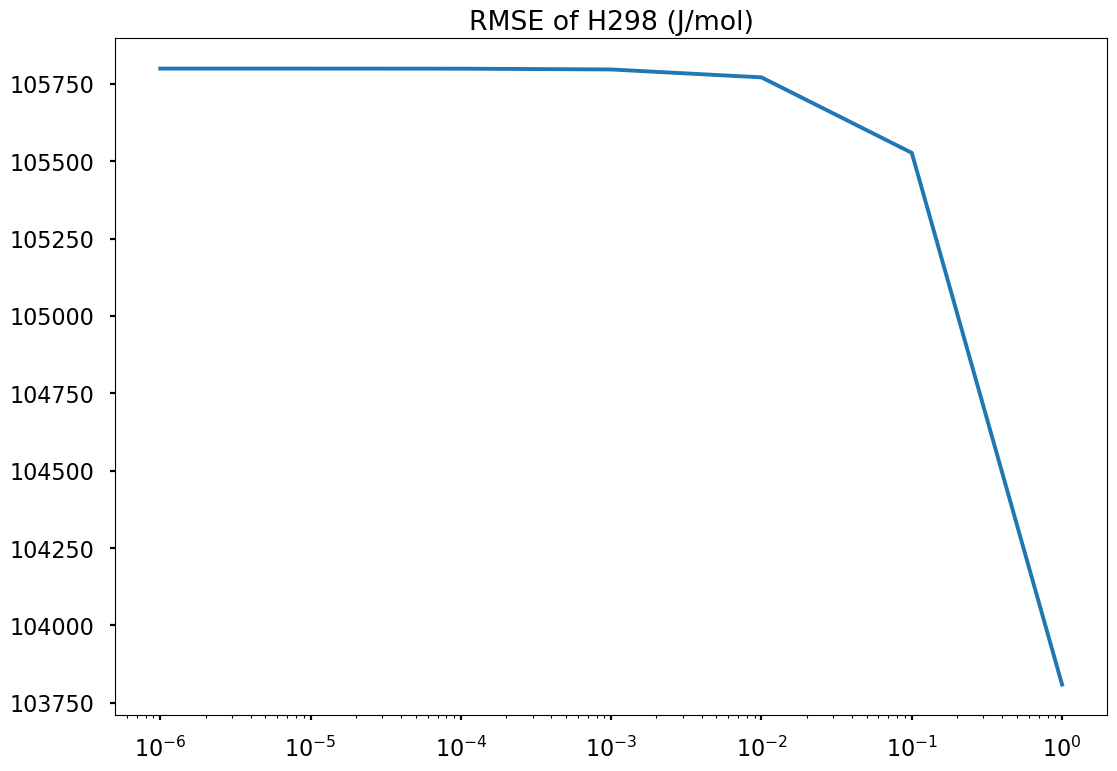

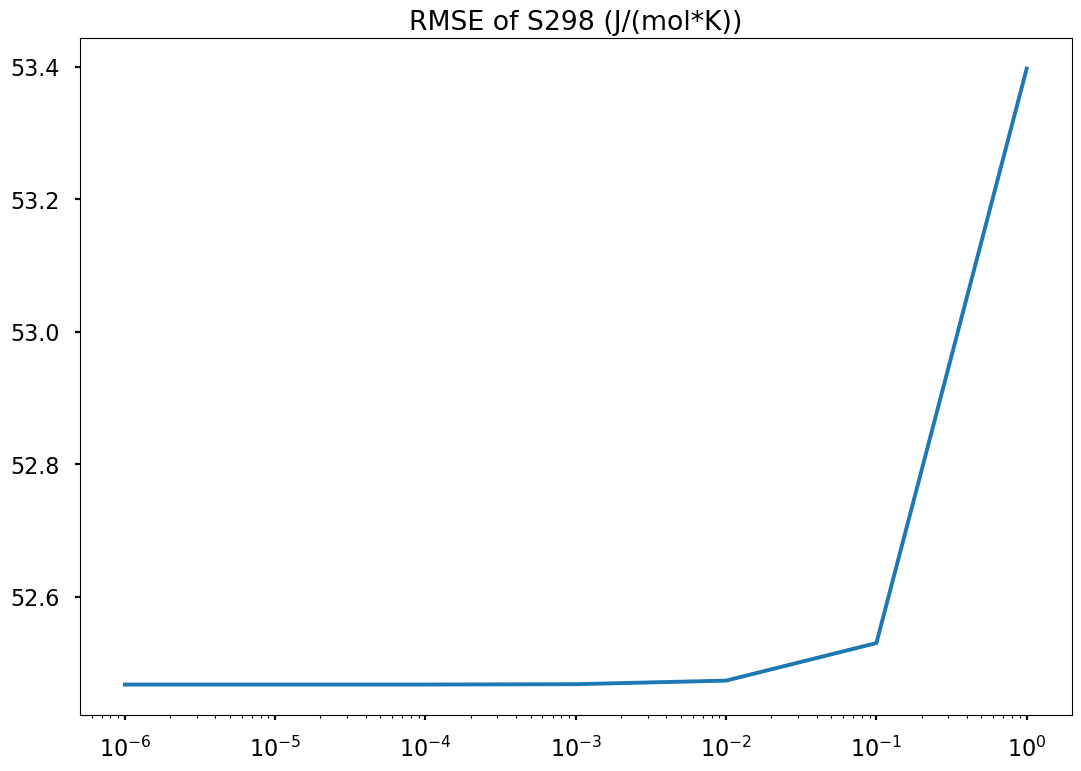

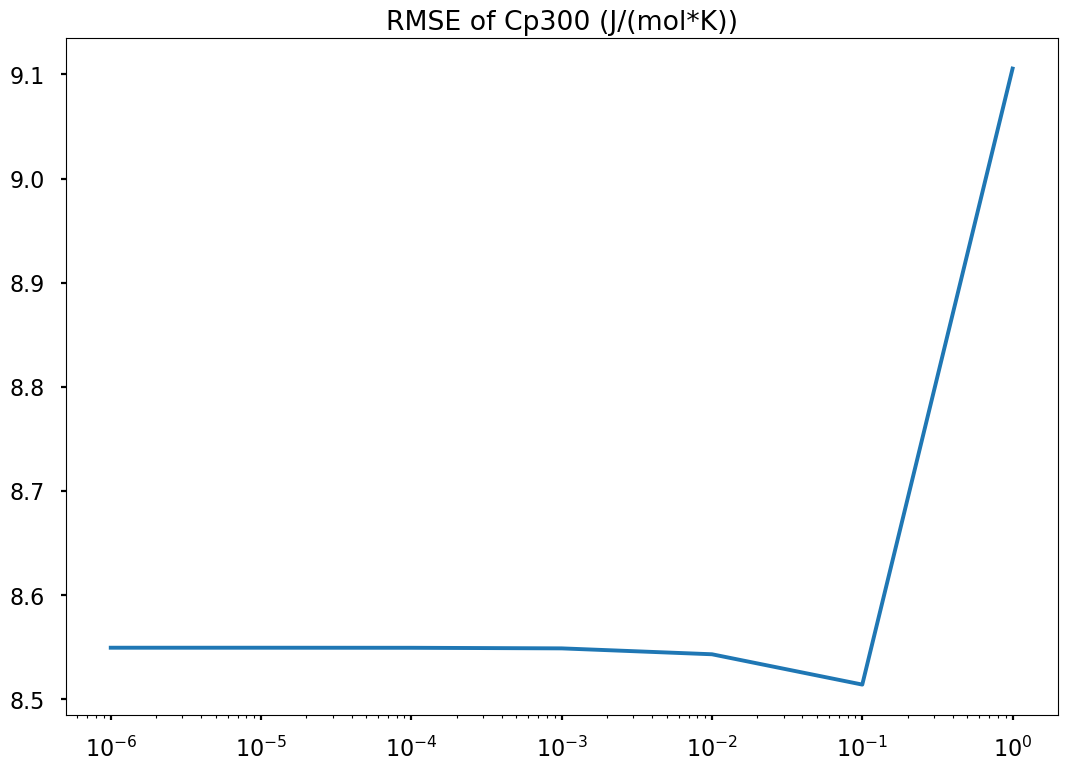

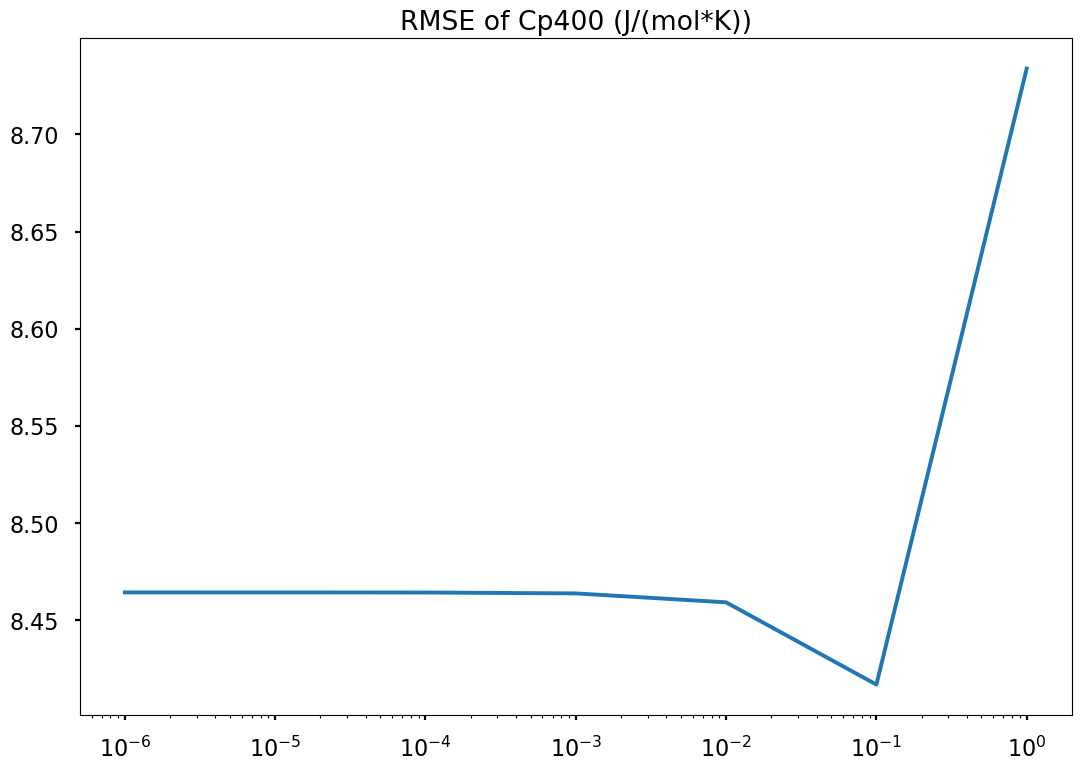

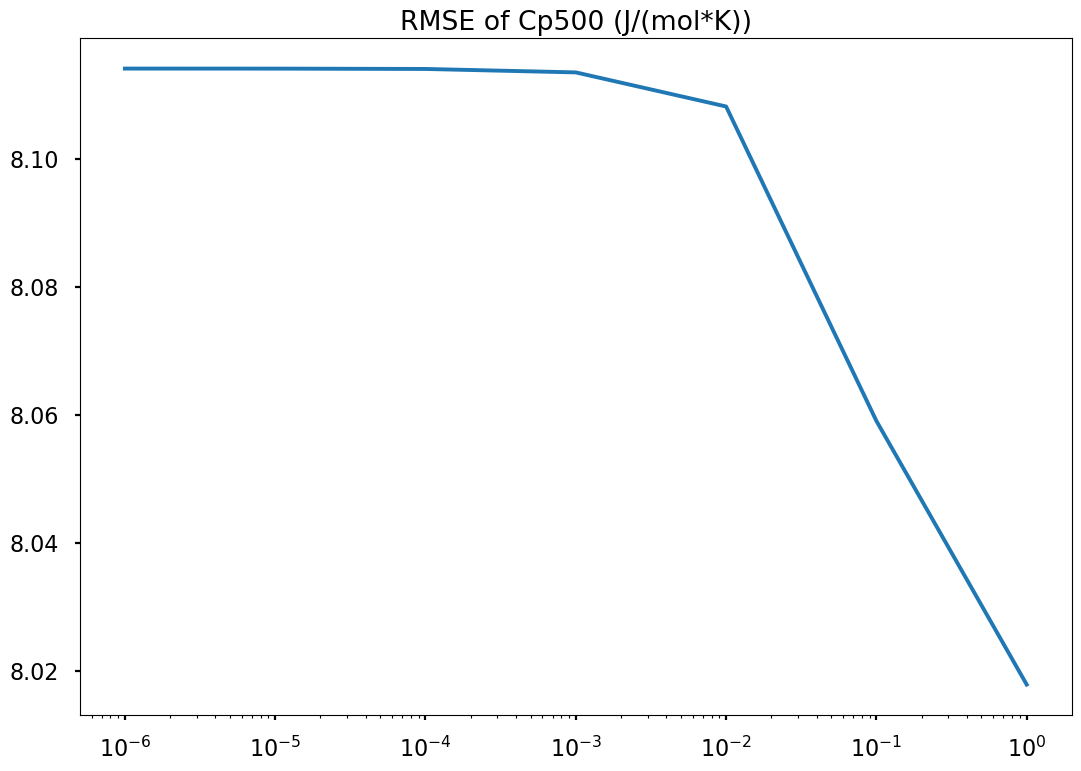

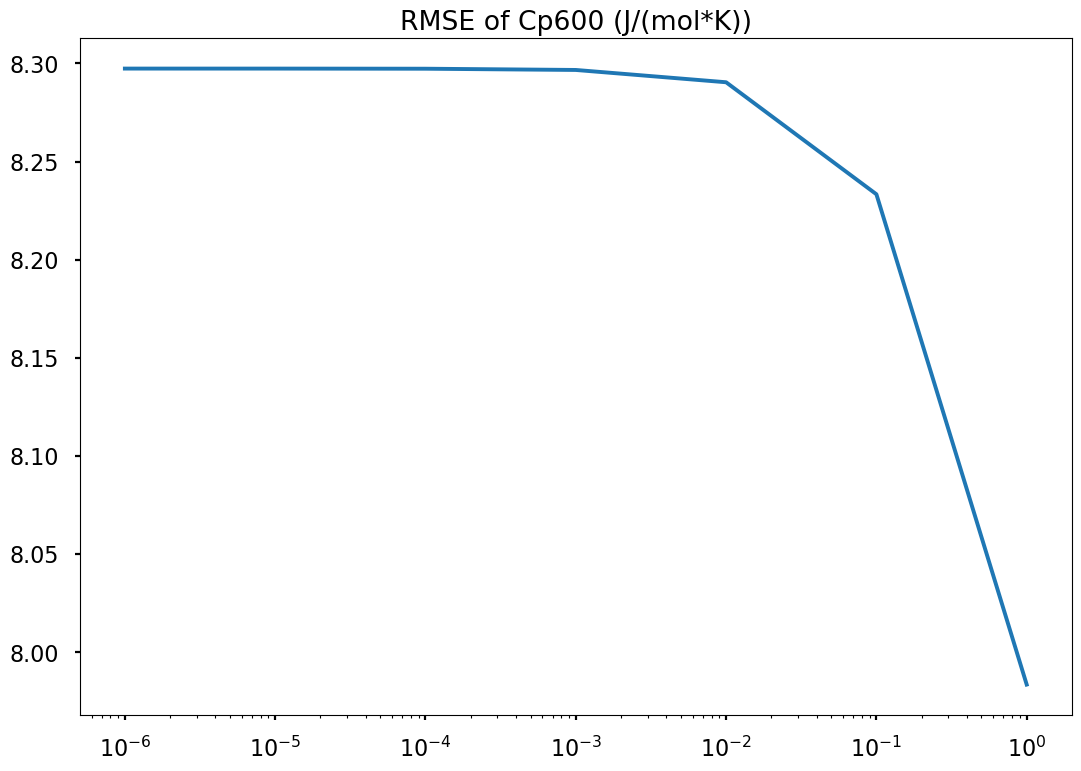

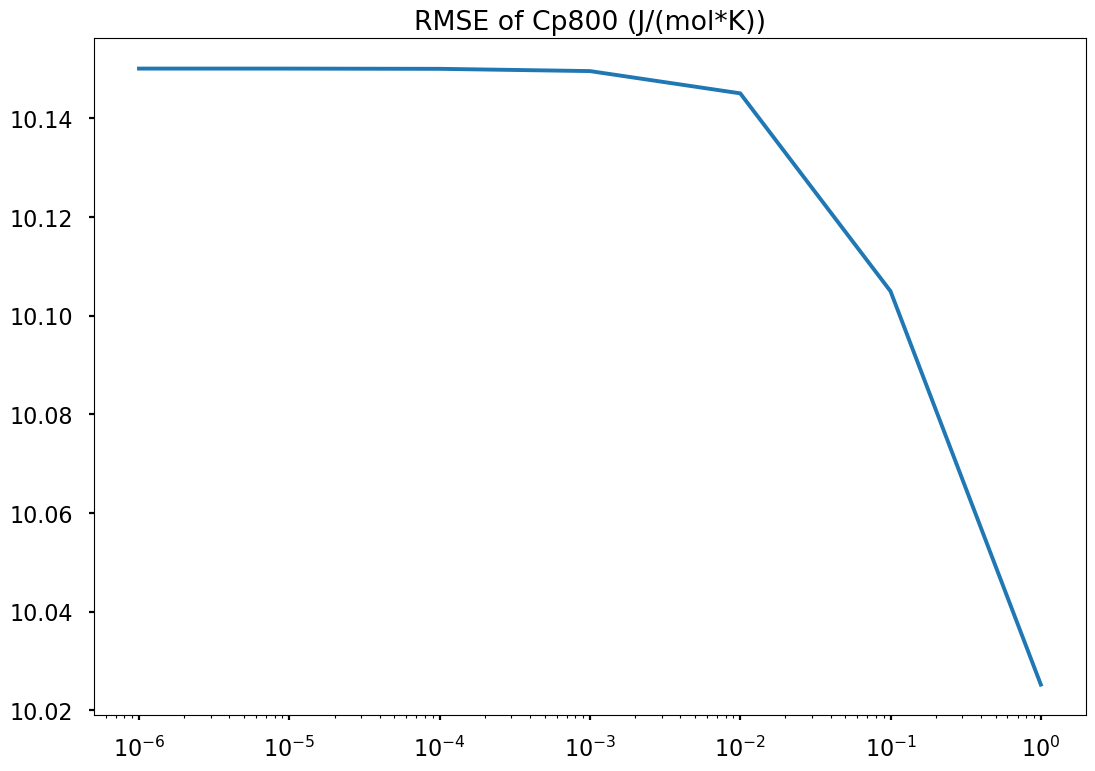

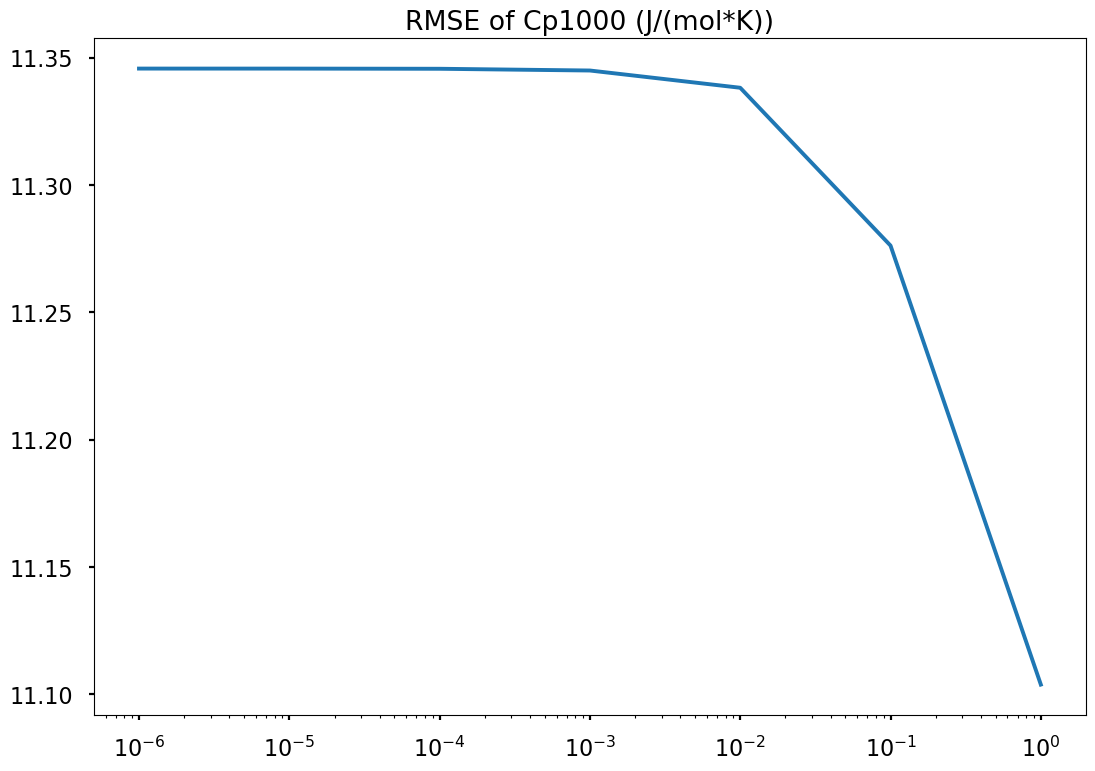

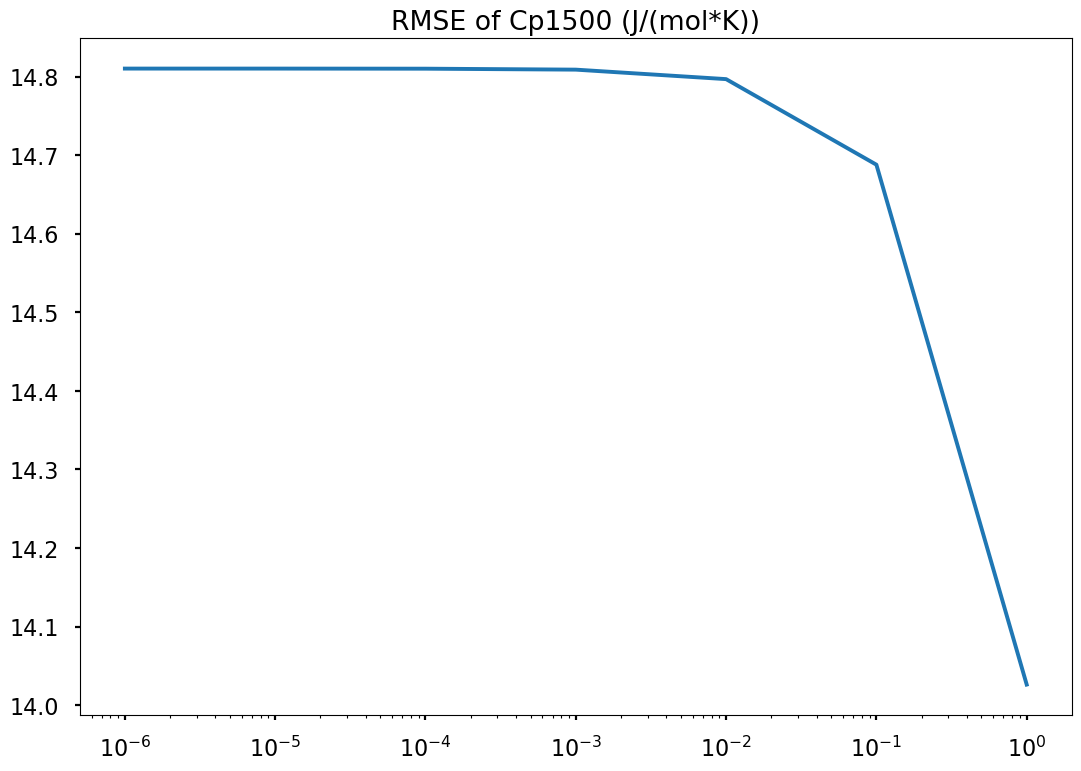

In [40]:
for ind,item in enumerate(group_data_items):
    plt.figure()
    cv = soln_dict["RidgeCV"].cv_values_
    rmse = [sum((cv[:,ind,alpha_ind])**0.5)/cv.shape[0] for alpha_ind in range(cv.shape[2])]
    plt.plot(soln_dict["RidgeCV"].alphas,rmse)
    plt.title(f"RMSE of {item[0]} ({item[1]})")
    plt.xscale("log")

## 2.5 Calculate uncertainty

In [41]:
b_pred = soln_dict["RidgeCV"].predict(A)

standard_error = dict()
for i in range(b.shape[1]):
    residuals = b[:,i] - b_pred[:,i]
    sigma_squared_hat = residuals.T @ residuals/(A.shape[0] - A.shape[1])
    #See https://arxiv.org/abs/1509.09169 Section 1.4.2 for derivation
    var_beta_hat = sigma_squared_hat * np.linalg.inv(A.T @ A + alpha*np.identity(A.shape[1])) @ A.T @ A @ (np.linalg.inv(A.T @ A + alpha*np.identity(A.shape[1]))).T
    standard_error[i] = np.diagonal(var_beta_hat)**0.5

## 2.6 Write the fitted data to ThermoData format

In [42]:
fitted_group_data = dict()
x = soln_dict["RidgeCV"].coef_.T

for i, label in enumerate(missing_group_index_dict.keys()):
    if all(x[i,:]==0.0):
        group_label = label.split("_")[1]
        print(f"All fitted item for group {group_label} from species index {i} are zeros. {group_label} is a special group. Add {group_label} to special_list")
    H298, S298, Cpdata = x[i,0], x[i,1], x[i,2:9]
    H298_unc, S298_unc, Cpdata_unc = standard_error[0][i], standard_error[1][i], [standard_error[j][i] for j in range(2,9)]
    fitted_group_data[label] = ThermoData(
            Tdata=([300, 400, 500, 600, 800, 1000, 1500], "K"),
            Cpdata=(Cpdata, "J/(mol*K)", "+|-", Cpdata_unc),
            H298=(H298/1000, "kJ/mol", "+|-", H298_unc/1000),
            S298=(S298, "J/(mol*K)", "+|-", S298_unc),
            comment=f"fitted({label})",
        )

All fitted item for group Cs-(CdH)BsHHH from species index 2 are zeros. Cs-(CdH)BsHHH is a special group. Add Cs-(CdH)BsHHH to special_list
All fitted item for group Cs-(CsCs)BsHHH from species index 3 are zeros. Cs-(CsCs)BsHHH is a special group. Add Cs-(CsCs)BsHHH to special_list
All fitted item for group Cs-(CdCs)BsHHH from species index 4 are zeros. Cs-(CdCs)BsHHH is a special group. Add Cs-(CdCs)BsHHH to special_list
All fitted item for group Cs-(CdCd)BsHHH from species index 5 are zeros. Cs-(CdCd)BsHHH is a special group. Add Cs-(CdCd)BsHHH to special_list
All fitted item for group Cs-(F1sF1s)BsHHH from species index 6 are zeros. Cs-(F1sF1s)BsHHH is a special group. Add Cs-(F1sF1s)BsHHH to special_list
All fitted item for group Bs-F1sF1sF1s from species index 7 are zeros. Bs-F1sF1sF1s is a special group. Add Bs-F1sF1sF1s to special_list
All fitted item for group Bs-Cl1sCl1sCl1s from species index 8 are zeros. Bs-Cl1sCl1sCl1s is a special group. Add Bs-Cl1sCl1sCl1s to special_list

## 2.7 Calculate GA esitmated thermo using newly fitted groups

In [43]:
all_data["GAE with fitted GAV"]=list()

for spc_index, groups in enumerate(all_data["missing groups"]):

    GAE_without_estimated_GA = all_data["GAE without estimated GAV"][spc_index]

    fitted_thermo = deepcopy(GAE_without_estimated_GA)
    for group in groups:
        add_thermo_data_uncertainty(fitted_thermo,fitted_group_data[group])

    all_data["GAE with fitted GAV"].append(fitted_thermo)


# 3. Check quality of new groups

## 3.1 Look at parity plot for training error and uncertainty from fitting

Text(0.5, 1.0, 'RMSE: 58.2, MAE: 26.2 kcal/mol')

<Figure size 1000x1000 with 0 Axes>

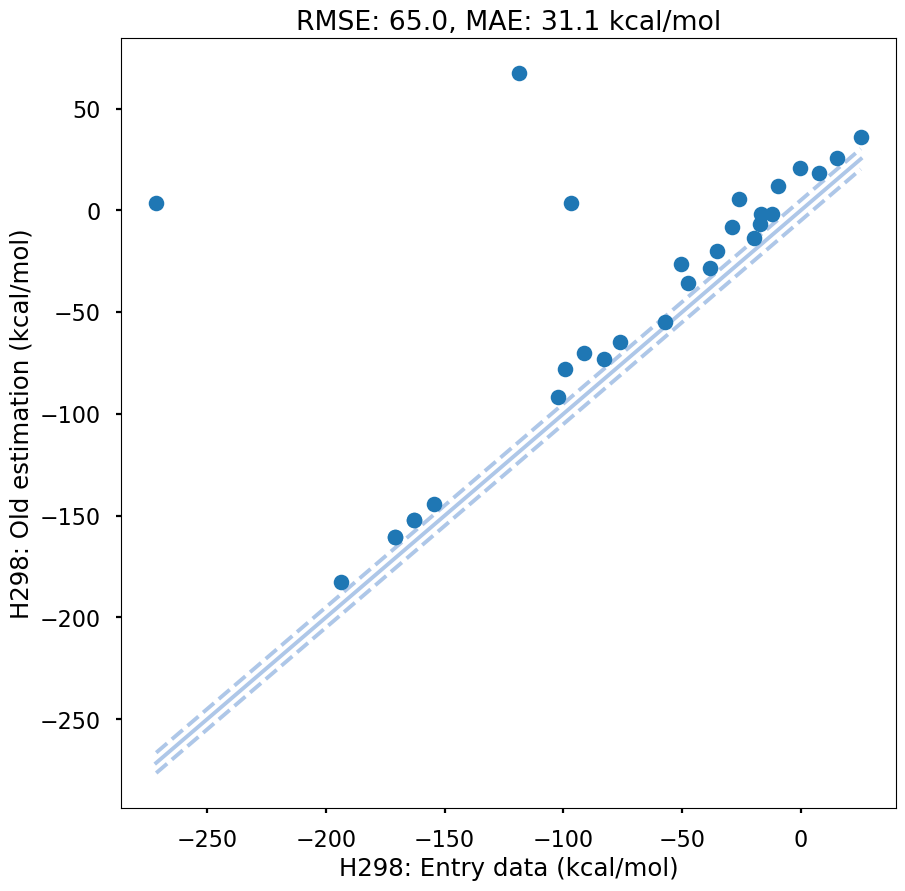

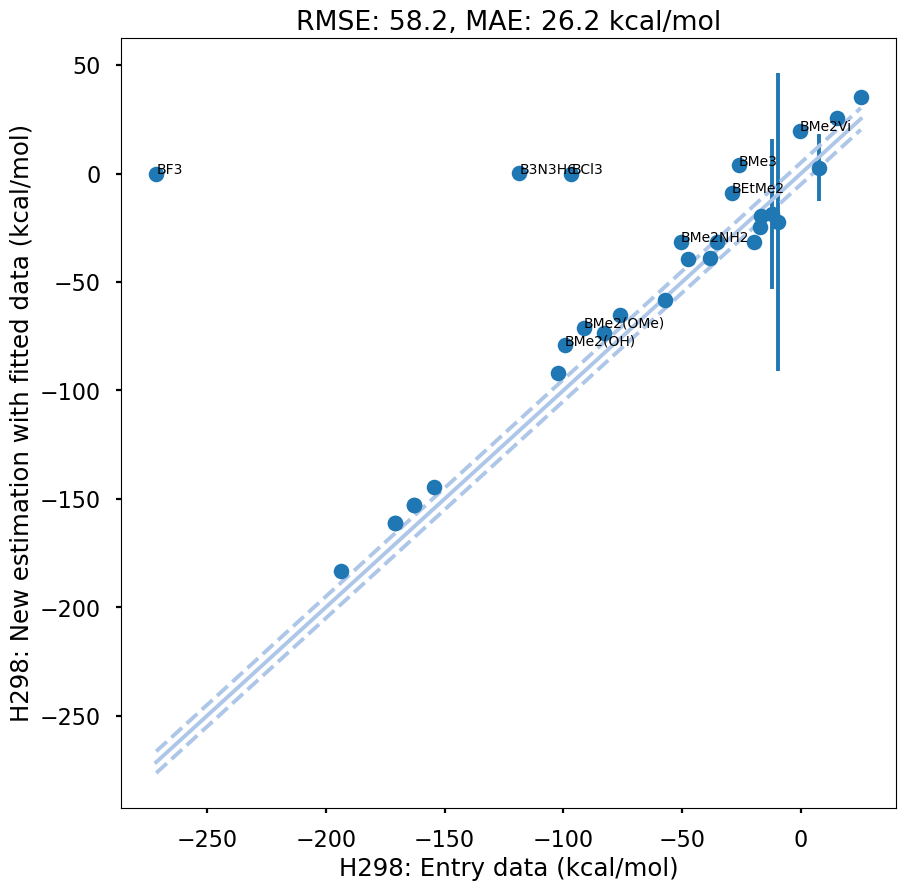

In [44]:
colormap = mpl.cm.tab20
plt.figure(figsize=(10,10))
entry_values = list()
old_GAE_values = list()
new_GAE_values = list()
new_GAE_uncertainties = list()
new_new_GAE_values = list()

for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_values.append(entry_thermo.H298.value_si/4180)
    estimated_GAE = all_data["GAE with estimated GAV"][spc_index]
    old_GAE_values.append(estimated_GAE.H298.value_si/4180)
    fitted_GAE = all_data["GAE with fitted GAV"][spc_index]
    new_GAE_values.append(fitted_GAE.H298.value_si/4180)
    new_GAE_uncertainties.append(fitted_GAE.H298.uncertainty_si/4180)


plt.figure(figsize=(10,10))
plt.errorbar(entry_values,old_GAE_values,fmt='o')
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
RMSE = mean_squared_error(entry_values,old_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,old_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} kcal/mol')
plt.xlabel("H298: Entry data (kcal/mol)")
plt.ylabel("H298: Old estimation (kcal/mol)")

plt.figure(figsize=(10,10))
plt.errorbar(x=entry_values,y=new_GAE_values,yerr=new_GAE_uncertainties,fmt='o')
for i, entry_value in enumerate(entry_values):
    if abs(entry_value - new_GAE_values[i])>15:
        plt.text(entry_value, new_GAE_values[i], s=all_data["entry"][i].label)
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
plt.xlabel("H298: Entry data (kcal/mol)")
plt.ylabel("H298: New estimation with fitted data (kcal/mol)")
RMSE = mean_squared_error(entry_values,new_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,new_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} kcal/mol')

Text(0.5, 1.0, 'RMSE: 41.9, MAE: 37.5 cal/(mol*K)')

<Figure size 1000x1000 with 0 Axes>

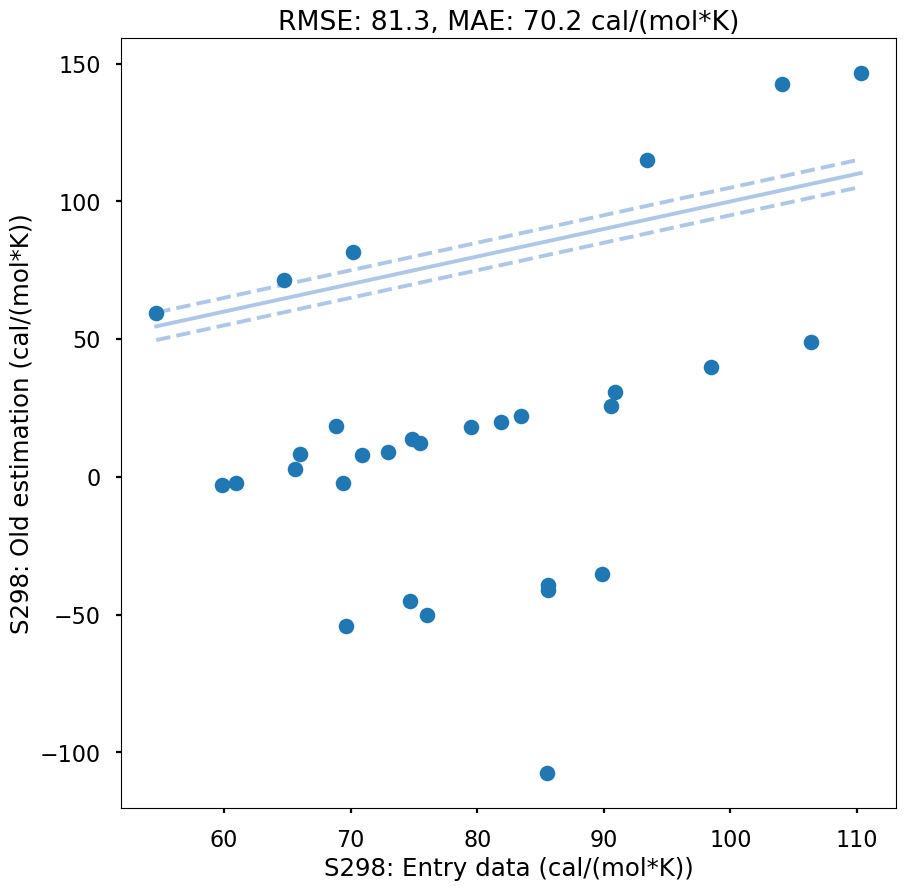

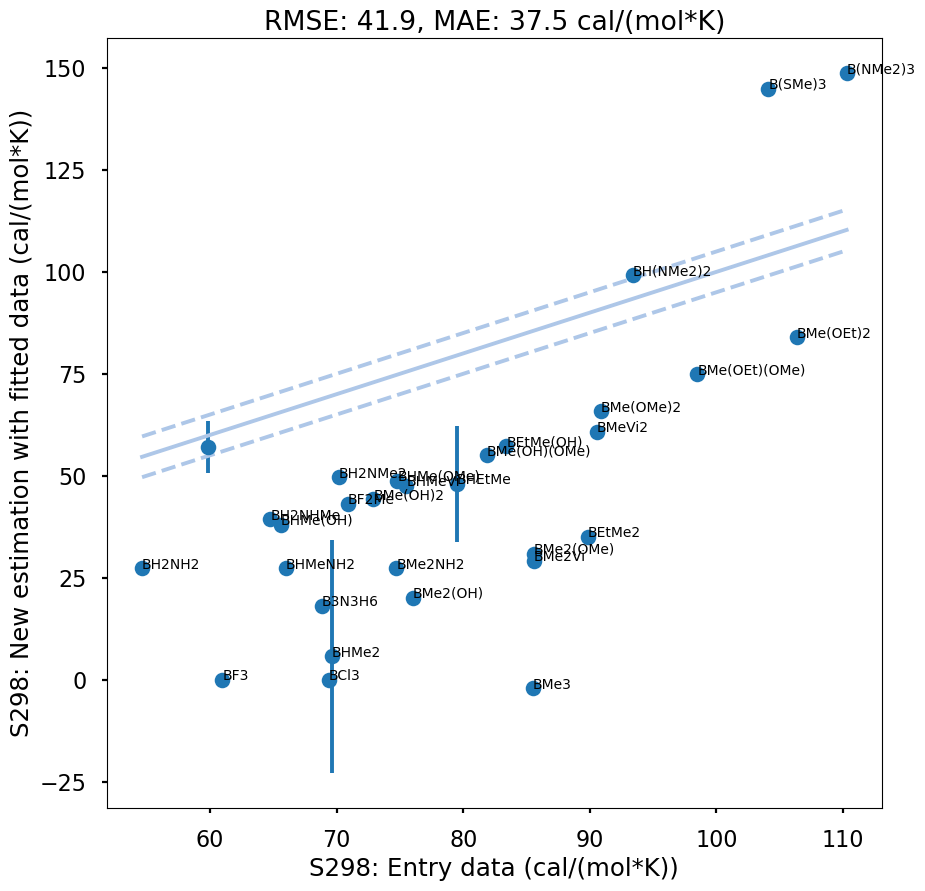

In [45]:
colormap = mpl.cm.tab20
plt.figure(figsize=(10,10))
entry_values = list()
old_GAE_values = list()
new_GAE_values = list()
new_GAE_uncertainties = list()
new_new_GAE_values = list()


for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_values.append(entry_thermo.S298.value_si/4.180)
    estimated_GAE = all_data["GAE with estimated GAV"][spc_index]
    old_GAE_values.append(estimated_GAE.S298.value_si/4.180)
    fitted_GAE = all_data["GAE with fitted GAV"][spc_index]
    new_GAE_values.append(fitted_GAE.S298.value_si/4.180)
    new_GAE_uncertainties.append(fitted_GAE.S298.uncertainty_si/4.180)

plt.figure(figsize=(10,10))
plt.errorbar(entry_values,old_GAE_values,fmt='o')
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
RMSE = mean_squared_error(entry_values,old_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,old_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} cal/(mol*K)')
plt.xlabel("S298: Entry data (cal/(mol*K))")
plt.ylabel("S298: Old estimation (cal/(mol*K))")

plt.figure(figsize=(10,10))
plt.errorbar(x=entry_values,y=new_GAE_values,yerr=new_GAE_uncertainties,fmt='o')
for i, entry_value in enumerate(entry_values):
    if abs(entry_value - new_GAE_values[i])>5:
        plt.text(entry_value, new_GAE_values[i], s=all_data["entry"][i].label)
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
plt.xlabel("S298: Entry data (cal/(mol*K))")
plt.ylabel("S298: New estimation with fitted data (cal/(mol*K))")
RMSE = mean_squared_error(entry_values,new_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,new_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} cal/(mol*K)')

# plt.figure()
# plt.hist(np.array(entry_values)-np.array(new_GAE_values),alpha=0.5,label="New GA estimation")
# plt.hist(np.array(entry_values)-np.array(old_GAE_values),alpha=0.5,label="Old GA estimation")
# plt.xlabel("S298 error (cal/mol-K)")
# plt.ylabel("Counts (-)")
# plt.legend()

## 3.2 Look at generalizability of the new groups by comparing the old estimation and the one-fold cross-validation of new estimation

/home/ssun30/mambaforge/envs/rmg_env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,
/home/ssun30/mambaforge/envs/rmg_env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,
/home/ssun30/mambaforge/envs/rmg_env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'norm

<Figure size 1000x1000 with 0 Axes>

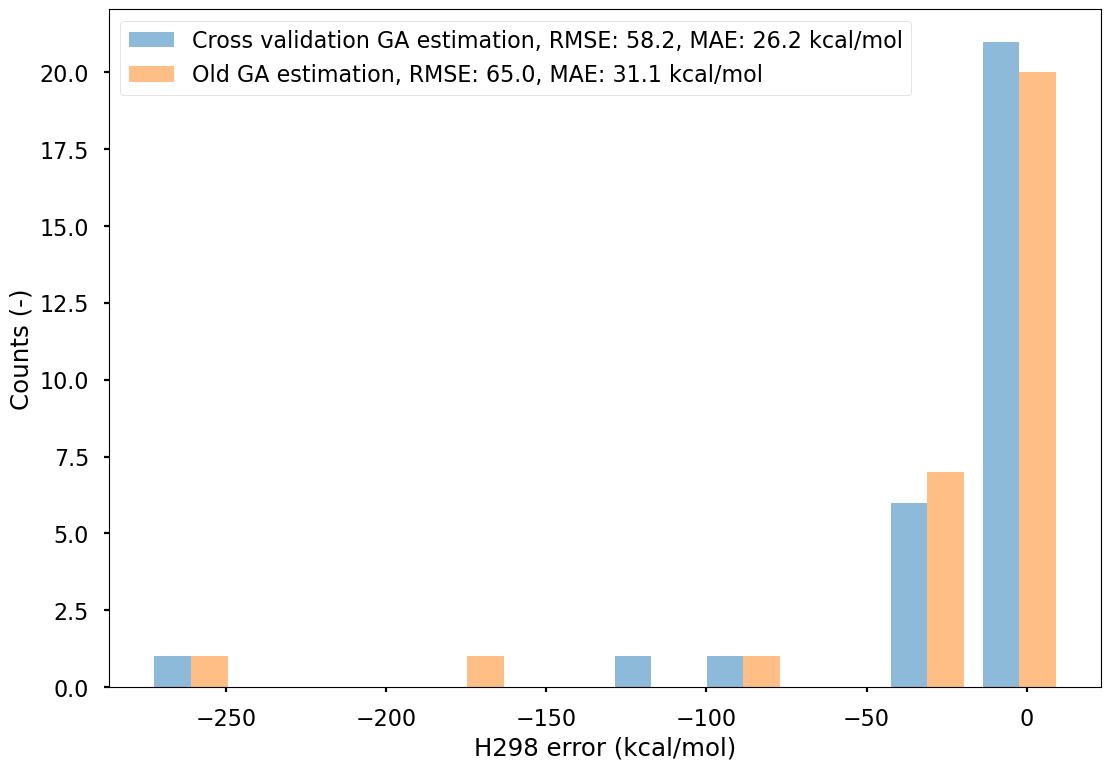

<Figure size 1000x1000 with 0 Axes>

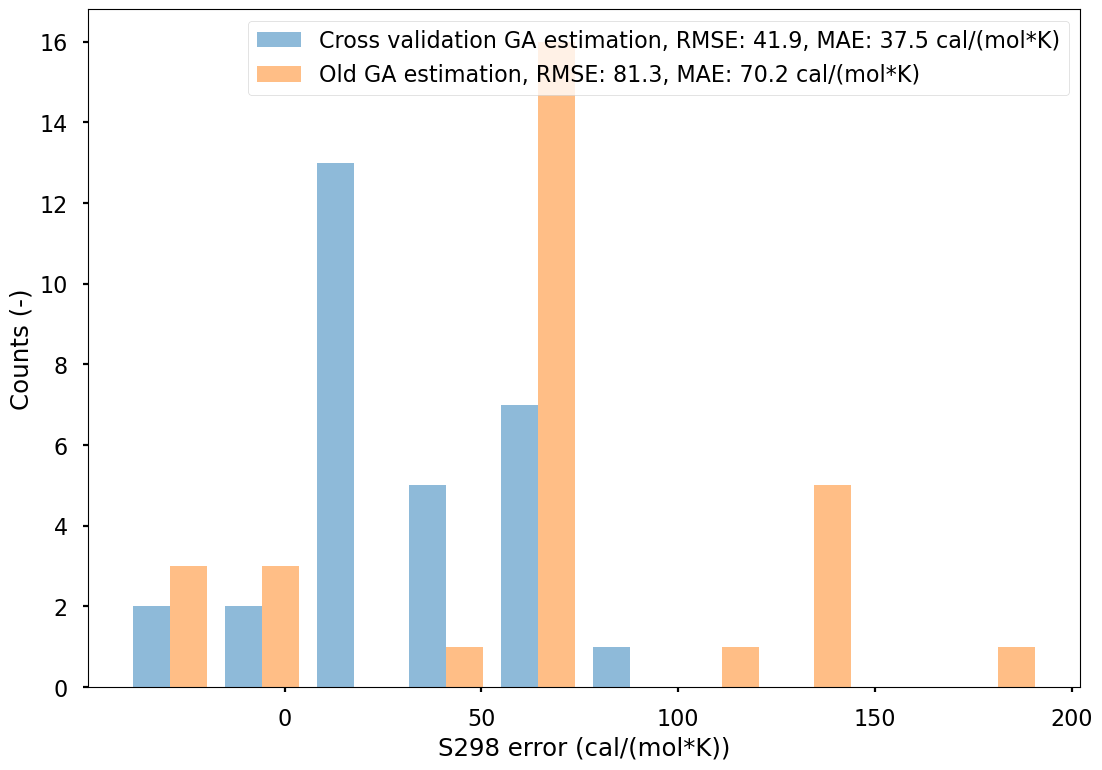

In [46]:
alpha = soln_dict["RidgeCV"].alpha_
all_data["cross validation estimation"]=list()
for skip_spc_index in range(spc_num):

    A = np.zeros((spc_num,grp_num))
    b = np.zeros((spc_num,len(group_data_items)))

    for spc_index, entry in enumerate(all_data["entry"]):
        if spc_index == skip_spc_index:
            pass
        else:
            groups = all_data["missing groups"][spc_index]
            for group in groups:
                A[spc_index, missing_group_index_dict[group]]+=1

            thermo_data = all_data["missing GAE"][spc_index]
            b[spc_index,0] = thermo_data.H298.value_si
            b[spc_index,1] = thermo_data.S298.value_si
            b[spc_index,2:9] = thermo_data.Cpdata.value_si

    soln = Ridge(alpha=alpha,fit_intercept=False,normalize=False, max_iter=1e5).fit(A,b)
    soln_dict["Ridge"]=soln

    b_pred = soln_dict["Ridge"].predict(A)

    standard_error = dict()
    for i in range(b.shape[1]):
        residuals = b[:,i] - b_pred[:,i]
        sigma_squared_hat = residuals.T @ residuals/(A.shape[0] - A.shape[1])
        var_beta_hat = sigma_squared_hat * np.linalg.inv(A.T @ A + alpha*np.identity(A.shape[1])) @ A.T @ A @ (np.linalg.inv(A.T @ A + alpha*np.identity(A.shape[1])))
        standard_error[i] = np.diagonal(var_beta_hat)**0.5

    fitted_group_data_cv = dict()

    for i, label in enumerate(missing_group_index_dict.keys()):
        x = soln_dict["Ridge"].coef_.T
        H298, S298, Cpdata = x[i,0], x[i,1], x[i,2:9]
        H298_unc, S298_unc, Cpdata_unc = standard_error[0][i], standard_error[1][i], [standard_error[j][i] for j in range(2,len(group_data_items))]
        fitted_group_data_cv[label] = ThermoData(
                Tdata=([300, 400, 500, 600, 800, 1000, 1500], "K"),
                Cpdata=(Cpdata, "J/(mol*K)", "+|-", Cpdata_unc),
                H298=(H298/1000, "kJ/mol", "+|-", H298_unc/1000),
                S298=(S298, "J/(mol*K)", "+|-", S298_unc),
                comment=f"fitted({label})",
            )

    groups = all_data["missing groups"][skip_spc_index]

    GAE_without_estimated_GA = all_data["GAE without estimated GAV"][skip_spc_index]

    fitted_thermo = deepcopy(GAE_without_estimated_GA)
    for group in groups:
        add_thermo_data_uncertainty(fitted_thermo,fitted_group_data_cv[group])

    all_data["cross validation estimation"].append(fitted_thermo)

colormap = mpl.cm.tab20
plt.figure(figsize=(10,10))
entry_values = list()
old_GAE_values = list()
cross_validation_values = list()

for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_values.append(entry_thermo.H298.value_si/4180)
    estimated_GAE = all_data["GAE with estimated GAV"][spc_index]
    old_GAE_values.append(estimated_GAE.H298.value_si/4180)
    cross_validation_GAE = all_data["cross validation estimation"][spc_index]
    cross_validation_values.append(cross_validation_GAE.H298.value_si/4180)

plt.figure()
RMSE1 = mean_squared_error(entry_values,cross_validation_values,squared=False)
MAE1 = mean_absolute_error(entry_values,cross_validation_values)
RMSE = mean_squared_error(entry_values,old_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,old_GAE_values)
plt.hist([np.array(entry_values)-np.array(cross_validation_values), np.array(entry_values)-np.array(old_GAE_values)],alpha=0.5,label=[f"Cross validation GA estimation, RMSE: {RMSE1:.1f}, MAE: {MAE1:.1f} kcal/mol",f"Old GA estimation, RMSE: {RMSE:.1f}, MAE: {MAE:.1f} kcal/mol"])
plt.xlabel("H298 error (kcal/mol)")
plt.ylabel("Counts (-)")
plt.legend()

colormap = mpl.cm.tab20
plt.figure(figsize=(10,10))
entry_values = list()
old_GAE_values = list()
cross_validation_values = list()

for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_values.append(entry_thermo.S298.value_si/4.180)
    estimated_GAE = all_data["GAE with estimated GAV"][spc_index]
    old_GAE_values.append(estimated_GAE.S298.value_si/4.180)
    cross_validation_GAE = all_data["cross validation estimation"][spc_index]
    cross_validation_values.append(cross_validation_GAE.S298.value_si/4.180)

plt.figure()
RMSE1 = mean_squared_error(entry_values,cross_validation_values,squared=False)
MAE1 = mean_absolute_error(entry_values,cross_validation_values)
RMSE = mean_squared_error(entry_values,old_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,old_GAE_values)
plt.hist([np.array(entry_values)-np.array(cross_validation_values), np.array(entry_values)-np.array(old_GAE_values)],alpha=0.5,label=[f"Cross validation GA estimation, RMSE: {RMSE1:.1f}, MAE: {MAE1:.1f} cal/(mol*K)", f"Old GA estimation, RMSE: {RMSE:.1f}, MAE: {MAE:.1f} cal/(mol*K)"])
plt.xlabel("S298 error (cal/(mol*K))")
plt.ylabel("Counts (-)")
plt.legend()

## 3.2 Check if there's bad fit
This block checks if there are any bad fit groups. User should expect this block prints out nothing. It this block prints out anything, user should not trust the fitted results and should open an issue or try to identify the reason of the poor fit. It uses following criteria to find bad fit:

- Error in H298 and S298 from the new estimation is worse than the old estimation. This is usually caused by special groups. Try identify the special groups and put in the `special_list`, and re-run the code. 

- Error in H298 from the new estimation `> n kcal/mol` or S298 `> n cal/(mol* K)`, where n is default to 5. Increase n at your own risk.

In [ ]:
bad_fit_spc_index_list = list()
n = 5
for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_thermo = all_data["entry thermo"][spc_index]
    diff = abs(entry_thermo.H298.value_si - all_data["GAE with estimated GAV"][spc_index].H298.value_si)
    diff_new = abs(entry_thermo.H298.value_si - all_data["GAE with fitted GAV"][spc_index].H298.value_si)
    if diff < diff_new:
        bad_fit_spc_index_list.append(spc_index)
    if diff_new > n * 4.18 * 1000:
        bad_fit_spc_index_list.append(spc_index)
    diff = abs(entry_thermo.S298.value_si - all_data["GAE with estimated GAV"][spc_index].S298.value_si)
    diff_new = abs(entry_thermo.S298.value_si - all_data["GAE with fitted GAV"][spc_index].S298.value_si)
    if diff < diff_new:
        bad_fit_spc_index_list.append(spc_index)
    if diff_new > n * 4.18:
        bad_fit_spc_index_list.append(spc_index)

# Remove duplicates
bad_fit_spc_index_list = list(set(bad_fit_spc_index_list))

In [ ]:
print(f"{len(bad_fit_spc_index_list)} out of {len(entries)} species have bad fits")
print("These are the bad fits:")

CBC
Entry
Boron_Vuori
BHMe2
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([68.3325,84.6727,99.8,113.292,135.408,152.1,178.529],'J/(mol*K)'), H298=(-39.7,'kJ/mol'), S298=(291,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'), E0=(-53.5826,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([53.5972,69.794,81.5885,89.4828,98.0892,101.304,103.948],'J/(mol*K)'), H298=(49.184,'kJ/mol'), S298=(-226.717,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsCs) + group(Cs-CsCsCsCs) + group(BHCs2)""")

missing
['Cs_Cs-(CsH)BsHHH', 'Cs_Cs-(CsH)BsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.029,18.4982,20,21.5346,24.7018,28,36],'J/(mol*K)'), H298=(45,'kJ/mol'), S298=(67,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(BHCs2)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([42.937

CBCC
Entry
Boron_Vuori
BHEtMe
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([90.2501,112.079,132.1,150,179.601,202.2,238.345],'J/(mol*K)'), H298=(-50.4,'kJ/mol'), S298=(332.4,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(295.164,'J/(mol*K)'), E0=(-67.5746,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([83.212,103.949,123.124,140.654,160.871,176.45,203.529],'J/(mol*K)'), H298=(-6.5848,'kJ/mol'), S298=(75.377,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-BCsHH) + group(Cs-CsHHH) + group(Cs-CsCsCsCs) + group(BHCs2)""")

missing
['Cs_Cs-(CsH)BsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([64.928,78.3008,92.3296,106.68,124.177,139.798,169.555],'J/(mol*K)'), H298=(-8.6768,'kJ/mol'), S298=(222.235,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-BCsHH) + group(Cs-CsHHH) + group(BHCs2)""")

GAE with fitted GAV
ThermoData(Tdata=

C=CBC
Entry
Boron_Vuori
BHMeVi
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([80.146,101.586,120.6,136.906,162.37,180.6,207.772],'J/(mol*K)'), H298=(64,'kJ/mol'), S298=(315.6,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'), E0=(48.929,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([71.6863,92.3998,111.216,124.177,141.085,153.806,180.161],'J/(mol*K)'), H298=(108.284,'kJ/mol'), S298=(51.6618,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsCs) + group(Cd-BCdH) + group(Cds-CdsHH) + group(BHCsCd)""")

missing
['Cs_Cs-(CdH)BsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([53.4022,66.7518,80.4218,90.2029,104.391,117.154,146.187],'J/(mol*K)'), H298=(106.192,'kJ/mol'), S298=(198.52,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cd-BCdH) + group(Cds-CdsHH) + group(BHCsCd)""")

GAE with fitted GAV
ThermoData(Td

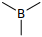

CB(C)C
Entry
Boron_Vuori
BMe3
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([91.052,112.86,132.7,150.334,179.338,201.4,236.663],'J/(mol*K)'), H298=(-109.6,'kJ/mol'), S298=(357.5,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(295.164,'J/(mol*K)'), E0=(-126.889,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([69.8649,92.5207,108.383,118.204,126.504,125.956,117.922],'J/(mol*K)'), H298=(22.276,'kJ/mol'), S298=(-449.575,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsCs) + group(Cs-CsCsCsCs) + group(Cs-CsCsCsCs) + group(BCs3)""")

missing
['Cs_Cs-(CsCs)BsHHH', 'Cs_Cs-(CsCs)BsHHH', 'Cs_Cs-(CsCs)BsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([15.0127,15.5769,16,16.2821,16.4231,16,16],'J/(mol*K)'), H298=(16,'kJ/mol'), S298=(-9,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(BCs3)""")

GAE with fitted GAV
ThermoData(Tdata=([300,

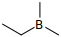

CCB(C)C
Entry
Boron_Vuori
BEtMe2
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([114.57,141.817,166.4,188.261,224.406,252.1,296.662],'J/(mol*K)'), H298=(-121.3,'kJ/mol'), S298=(375.6,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(365.837,'J/(mol*K)'), E0=(-142.178,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([99.4798,126.675,149.918,169.376,189.286,201.101,217.503],'J/(mol*K)'), H298=(-33.4928,'kJ/mol'), S298=(-147.481,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-BCsHH) + group(Cs-CsHHH) + group(Cs-CsCsCsCs) + group(Cs-CsCsCsCs) + group(BCs3)""")

missing
['Cs_Cs-(CsCs)BsHHH', 'Cs_Cs-(CsCs)BsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([62.9117,75.3795,88.3296,101.427,115.899,127.798,149.555],'J/(mol*K)'), H298=(-37.6768,'kJ/mol'), S298=(146.235,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-BCsHH) + group(Cs-CsHHH) 

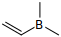

C=CB(C)C
Entry
Boron_Vuori
BMe2Vi
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([103.535,128.843,151.1,170.344,201.069,223.8,259.271],'J/(mol*K)'), H298=(-2.3,'kJ/mol'), S298=(357.8,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'), E0=(-21.1961,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([87.9182,113.454,135.01,148.88,164.372,173.457,187.135],'J/(mol*K)'), H298=(86.3758,'kJ/mol'), S298=(-172.197,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsCs) + group(Cs-CsCsCsCs) + group(Cd-BCdH) + group(Cds-CdsHH) + group(BCs2Cd)""")

missing
['Cs_Cs-(CdCs)BsHHH', 'Cs_Cs-(CdCs)BsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([51.35,62.158,73.4218,80.9321,90.9851,100.154,119.187],'J/(mol*K)'), H298=(82.1918,'kJ/mol'), S298=(121.52,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cd-BCdH) + group(Cds-CdsHH) + grou

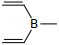

C=CB(C)C=C
Entry
Boron_Vuori
BMeVi2
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([115.001,143.152,167.5,188.289,221.052,245,281.962],'J/(mol*K)'), H298=(105.4,'kJ/mol'), S298=(378.6,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(345.051,'J/(mol*K)'), E0=(84.8999,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([106.956,134.752,161.638,179.446,202.676,222.959,260.348],'J/(mol*K)'), H298=(150.476,'kJ/mol'), S298=(107.182,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsCs) + group(Cd-BCdH) + group(Cd-BCdH) + group(Cds-CdsHH) + group(Cds-CdsHH) + group(BCsCd2)""")

missing
['Cs_Cs-(CdCd)BsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([88.6722,109.104,130.844,145.472,165.982,186.307,226.374],'J/(mol*K)'), H298=(148.384,'kJ/mol'), S298=(254.04,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cd-BCdH) + group(Cd-BCdH) + group(Cd

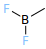

CB(F)F
Entry
Boron_Vuori
BF2Me
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([56.8576,69.1795,79.9,88.8736,102.432,111.8,125.389],'J/(mol*K)'), H298=(-809.4,'kJ/mol'), S298=(296.3,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(153.818,'J/(mol*K)'), E0=(-821.551,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([49.3872,61.5492,70.7942,77.3732,84.7924,86.6518,93.9741],'J/(mol*K)'), H298=(-763.908,'kJ/mol'), S298=(33.1416,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsCs) + group(BCsF2)""")

missing
['Cs_Cs-(F1sF1s)BsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([31.1031,35.9013,40,43.3991,48.0987,50,60],'J/(mol*K)'), H298=(-766,'kJ/mol'), S298=(180,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(BCsF2)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([31.1031,35.9013,40,43.3991,48.09

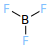

FB(F)F
Entry
Boron_Vuori
BF3
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([42.8452,49.6224,55.1,59.2725,64.6895,67.7,70.9146],'J/(mol*K)'), H298=(-1134.6,'kJ/mol'), S298=(254.9,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(83.1447,'J/(mol*K)'), E0=(-1144.95,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([15.0127,15.5769,16,16.2821,16.4231,16,16],'J/(mol*K)'), H298=(16,'kJ/mol'), S298=(-9,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(BCs3)""")

missing
['BR3_Bs-F1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

====


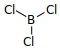

ClB(Cl)Cl
Entry
Boron_Vuori
BCl3
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([55.1374,60.9263,64.9,67.5603,70.4969,71.8,72.8211],'J/(mol*K)'), H298=(-404.3,'kJ/mol'), S298=(290,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(83.1447,'J/(mol*K)'), E0=(-417.101,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([15.0127,15.5769,16,16.2821,16.4231,16,16],'J/(mol*K)'), H298=(16,'kJ/mol'), S298=(-9,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(BCs3)""")

missing
['BR3_Bs-Cl1sCl1sCl1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

====


CBO
Entry
Boron_Vuori
BHMe(OH)
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([56.192,70.4965,83.4,94.4885,111.704,123.9,141.903],'J/(mol*K)'), H298=(-347.3,'kJ/mol'), S298=(274.2,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'), E0=(-359.058,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([48.3711,62.8852,75.7942,84.3493,94.6564,101.652,118.974],'J/(mol*K)'), H298=(-304.908,'kJ/mol'), S298=(12.1416,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-BH) + group(Cs-CsCsCsCs) + group(BHCsO)""")

missing
['Cs_Cs-(O2sH)BsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.087,37.2373,45,50.3752,57.9627,65,85],'J/(mol*K)'), H298=(-307,'kJ/mol'), S298=(159,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-BH) + group(BHCsO)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.0

CBOC
Entry
Boron_Vuori
BHMe(OMe)
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([74.6851,93.6526,111.3,127.099,153.05,172.6,203.184],'J/(mol*K)'), H298=(-318,'kJ/mol'), S298=(312.7,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(245.277,'J/(mol*K)'), E0=(-332.696,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([67.6811,86.4552,102.234,115.409,134.016,147.282,174.444],'J/(mol*K)'), H298=(-270.808,'kJ/mol'), S298=(57.2616,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-BC) + group(Cs-CsCsCsCs) + group(Cs-OsHHH) + group(BHCsO)""")

missing
['Cs_Cs-(O2sH)BsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([49.397,60.8073,71.44,81.4352,97.3227,110.63,140.47],'J/(mol*K)'), H298=(-272.9,'kJ/mol'), S298=(204.12,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-BC) + group(Cs-OsHHH) + group(BHCsO)""")

GAE with fitted GAV
ThermoData(Tdata

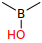

CB(C)O
Entry
Boron_Vuori
BMe2(OH)
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([77.8207,98.0722,116.1,131.63,156.051,173.7,200.395],'J/(mol*K)'), H298=(-415,'kJ/mol'), S298=(317.8,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(245.277,'J/(mol*K)'), E0=(-429.854,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([63.6145,83.4871,99.5885,109.421,118.796,122.304,127.948],'J/(mol*K)'), H298=(-326.816,'kJ/mol'), S298=(-209.717,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-BH) + group(Cs-CsCsCsCs) + group(Cs-CsCsCsCs) + group(BCs2O)""")

missing
['Cs_Cs-(CsO2s)BsHHH', 'Cs_Cs-(CsO2s)BsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([27.0463,32.1913,38,41.4725,45.4087,49,60],'J/(mol*K)'), H298=(-331,'kJ/mol'), S298=(84,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-BH) + group(BCs2O)""")

GAE with fitted GAV
ThermoData(Tdata=([300

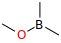

COB(C)C
Entry
Boron_Vuori
BMe2(OMe)
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([99.612,124.091,146,165.214,196.354,219.7,256.478],'J/(mol*K)'), H298=(-381.7,'kJ/mol'), S298=(357.7,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(315.95,'J/(mol*K)'), E0=(-400.089,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([82.9245,107.057,126.028,140.481,158.156,167.934,183.418],'J/(mol*K)'), H298=(-292.716,'kJ/mol'), S298=(-164.597,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-BC) + group(Cs-CsCsCsCs) + group(Cs-CsCsCsCs) + group(Cs-OsHHH) + group(BCs2O)""")

missing
['Cs_Cs-(CsO2s)BsHHH', 'Cs_Cs-(CsO2s)BsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([46.3563,55.7613,64.44,72.5325,84.7687,94.63,115.47],'J/(mol*K)'), H298=(-296.9,'kJ/mol'), S298=(129.12,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-BC) + group(Cs-OsHHH) + group(B

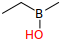

CCB(C)O
Entry
Boron_Vuori
BEtMe(OH)
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([99.5479,125.681,148.8,168.766,200.432,223.6,259.135],'J/(mol*K)'), H298=(-427.2,'kJ/mol'), S298=(348.7,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(315.95,'J/(mol*K)'), E0=(-445.189,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([93.2293,117.642,141.124,160.592,181.578,197.45,227.529],'J/(mol*K)'), H298=(-382.585,'kJ/mol'), S298=(92.377,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-BH) + group(Cs-BCsHH) + group(Cs-CsHHH) + group(Cs-CsCsCsCs) + group(BCs2O)""")

missing
['Cs_Cs-(CsO2s)BsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([74.9453,91.9939,110.33,126.618,144.884,160.798,193.555],'J/(mol*K)'), H298=(-384.677,'kJ/mol'), S298=(239.235,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-BH) + group(Cs-BCsHH) + group(Cs-CsHHH) + group(B

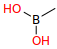

CB(O)O
Entry
Boron_Vuori
BMe(OH)2
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([70.579,88.4457,103.6,116.009,134.234,146.4,163.256],'J/(mol*K)'), H298=(-713.6,'kJ/mol'), S298=(304.8,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(195.39,'J/(mol*K)'), E0=(-727.27,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([63.342,79.387,94.7942,103.815,112.955,119.652,135.974],'J/(mol*K)'), H298=(-670.908,'kJ/mol'), S298=(38.1416,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-BH) + group(O2s-BH) + group(Cs-CsCsCsCs) + group(BCsO2)""")

missing
['Cs_Cs-(O2sO2s)BsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([45.0579,53.7391,64,69.8406,76.2609,83,102],'J/(mol*K)'), H298=(-673,'kJ/mol'), S298=(185,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-BH) + group(O2s-BH) + group(BCsO2)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,60

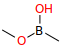

COB(C)O
Entry
Boron_Vuori
BMe(OH)(OMe)
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([88.9865,111.993,131.9,148.683,174.474,192.7,219.699],'J/(mol*K)'), H298=(-680,'kJ/mol'), S298=(342.3,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(266.063,'J/(mol*K)'), E0=(-696.378,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([82.652,102.957,121.234,134.875,152.315,165.282,191.444],'J/(mol*K)'), H298=(-636.808,'kJ/mol'), S298=(83.2616,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-BC) + group(O2s-BH) + group(Cs-CsCsCsCs) + group(Cs-OsHHH) + group(BCsO2)""")

missing
['Cs_Cs-(O2sO2s)BsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([64.3679,77.3091,90.44,100.901,115.621,128.63,157.47],'J/(mol*K)'), H298=(-638.9,'kJ/mol'), S298=(230.12,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-BC) + group(O2s-BH) + group(Cs-OsHHH) + group(BCsO2)"

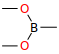

COB(C)OC
Entry
Boron_Vuori
BMe(OMe)2
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([109.743,135.527,158.5,178.69,211.616,236.5,276.009],'J/(mol*K)'), H298=(-646.1,'kJ/mol'), S298=(379.8,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(336.736,'J/(mol*K)'), E0=(-666.219,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([101.962,126.527,147.674,165.935,191.675,210.912,246.914],'J/(mol*K)'), H298=(-602.708,'kJ/mol'), S298=(128.382,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-BC) + group(O2s-BC) + group(Cs-CsCsCsCs) + group(Cs-OsHHH) + group(Cs-OsHHH) + group(BCsO2)""")

missing
['Cs_Cs-(O2sO2s)BsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([83.6779,100.879,116.88,131.961,154.981,174.26,212.94],'J/(mol*K)'), H298=(-604.8,'kJ/mol'), S298=(275.24,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-BC) + group(O2s-BC) + group(Cs-OsH

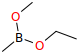

CCOB(C)OC
Entry
Boron_Vuori
BMe(OEt)(OMe)
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([131.227,165.436,195.2,220.718,261.067,290.6,336.04],'J/(mol*K)'), H298=(-680.4,'kJ/mol'), S298=(411.7,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(407.409,'J/(mol*K)'), E0=(-702.963,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([127.561,159.16,186.014,208.9,241.32,265.39,308.529],'J/(mol*K)'), H298=(-636.785,'kJ/mol'), S298=(166.147,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-BC) + group(O2s-BC) + group(Cs-CsOsHH) + group(Cs-CsHHH) + group(Cs-CsCsCsCs) + group(Cs-OsHHH) + group(BCsO2)""")

missing
['Cs_Cs-(O2sO2s)BsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([109.277,133.512,155.22,174.926,204.627,228.738,274.555],'J/(mol*K)'), H298=(-638.877,'kJ/mol'), S298=(313.005,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-BC) + grou

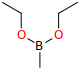

CCOB(C)OCC
Entry
Boron_Vuori
BMe(OEt)2
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([154.279,195.361,230.7,260.738,307.814,342,394.278],'J/(mol*K)'), H298=(-713.8,'kJ/mol'), S298=(444.5,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(478.082,'J/(mol*K)'), E0=(-739.459,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([153.16,191.792,224.353,251.865,290.966,319.867,370.144],'J/(mol*K)'), H298=(-670.862,'kJ/mol'), S298=(203.912,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-BC) + group(O2s-BC) + group(Cs-CsOsHH) + group(Cs-CsOsHH) + group(Cs-CsHHH) + group(Cs-CsHHH) + group(Cs-CsCsCsCs) + group(BCsO2)""")

missing
['Cs_Cs-(O2sO2s)BsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.876,166.144,193.559,217.891,254.272,283.215,336.169],'J/(mol*K)'), H298=(-672.954,'kJ/mol'), S298=(350.771,'J/(mol*K)'), comment="""Thermo group additivity estimation: 

BN
Entry
Boron_Vuori
BH2NH2
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([39.4029,49.6473,59.1,67.2045,79.5712,88.1,100.344],'J/(mol*K)'), H298=(-81.9,'kJ/mol'), S298=(228.4,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(128.874,'J/(mol*K)'), E0=(-91.154,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([45.1739,53.4745,61,67.7503,78.9255,87,113],'J/(mol*K)'), H298=(-57,'kJ/mol'), S298=(248,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(N3s-H2B) + group(BH2Cs)""")

missing
['BH2R_Bs-(HH)N3sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([24.0997,28.8141,33,36.6572,42.3859,46,59],'J/(mol*K)'), H298=(-131,'kJ/mol'), S298=(114,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(N3s-H2B)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([24.0997,28.8141,33,36.6572,42.3859,46,59],'J/(mol*K)'), H298=(-13

BNC
Entry
Boron_Vuori
BH2NHMe
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([58.4104,73.9042,88.4,101.28,122.105,137.5,161.177],'J/(mol*K)'), H298=(-72.6,'kJ/mol'), S298=(270.7,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(199.547,'J/(mol*K)'), E0=(-84.7188,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([71.0304,81.9781,92.275,101.593,118.414,132.415,166.694],'J/(mol*K)'), H298=(-28.7618,'kJ/mol'), S298=(298.145,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(N3s-CsHB) + group(Cs-N3sHHH) + group(BH2Cs)""")

missing
['BH2R_Bs-(CsH)N3sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([49.9562,57.3177,64.275,70.4994,81.8748,91.4149,112.694],'J/(mol*K)'), H298=(-102.762,'kJ/mol'), S298=(164.145,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(N3s-CsHB) + group(Cs-N3sHHH)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,100

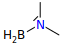

BN(C)C
Entry
Boron_Vuori
BH2NMe2
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([82.0483,103.828,123.6,140.954,168.866,189.5,221.336],'J/(mol*K)'), H298=(-70,'kJ/mol'), S298=(293.4,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'), E0=(-85.5075,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([99.9273,115.27,129.55,142.109,164.315,181.83,222.388],'J/(mol*K)'), H298=(-7.52355,'kJ/mol'), S298=(341.291,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(N3s-Cs2B) + group(Cs-N3sHHH) + group(Cs-N3sHHH) + group(BH2Cs)""")

missing
['BH2R_Bs-(CsCs)N3sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([78.8531,90.61,101.55,111.016,127.775,140.83,168.388],'J/(mol*K)'), H298=(-81.5235,'kJ/mol'), S298=(207.291,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(N3s-Cs2B) + group(Cs-N3sHHH) + group(Cs-N3sHHH)""")

GAE with fitted GAV
Thermo

CBN
Entry
Boron_Vuori
BHMeNH2
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([62.5243,78.3071,92.5,104.746,123.961,137.8,158.742],'J/(mol*K)'), H298=(-147,'kJ/mol'), S298=(275.8,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(199.547,'J/(mol*K)'), E0=(-159.717,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([59.4128,72.9602,83.7942,92.1659,103.781,110.652,128.974],'J/(mol*K)'), H298=(-83.908,'kJ/mol'), S298=(34.1416,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(N3s-H2B) + group(Cs-CsCsCsCs) + group(BHCs2)""")

missing
['Cs_Cs-(N3sH)BsHHH', 'BHR2_Bs-(HH)(HHH)CsN3sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([24.0997,28.8141,33,36.6572,42.3859,46,59],'J/(mol*K)'), H298=(-131,'kJ/mol'), S298=(114,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(N3s-H2B)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), C

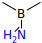

CB(N)C
Entry
Boron_Vuori
BMe2NH2
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([84.9488,106.435,125.5,141.97,168.084,187.2,216.687],'J/(mol*K)'), H298=(-211,'kJ/mol'), S298=(312.3,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'), E0=(-227.007,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([75.6806,95.6868,110.588,120.887,132.196,135.304,142.948],'J/(mol*K)'), H298=(-110.816,'kJ/mol'), S298=(-188.717,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(N3s-H2B) + group(Cs-CsCsCsCs) + group(Cs-CsCsCsCs) + group(BCs3)""")

missing
['Cs_Cs-(CsN3s)BsHHH', 'Cs_Cs-(CsN3s)BsHHH', 'BR3_Bs-(HH)(HHH)(HHH)CsCsN3s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([24.0997,28.8141,33,36.6572,42.3859,46,59],'J/(mol*K)'), H298=(-131,'kJ/mol'), S298=(114,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(N3s-H2B)""")

GAE with fitted GAV
Therm

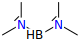

CN(BN(C)C)C
Entry
Boron_Vuori
BH(NMe2)2
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([146.975,183.736,216.5,245.363,292.574,328.3,384.743],'J/(mol*K)'), H298=(-160.2,'kJ/mol'), S298=(390.4,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(457.296,'J/(mol*K)'), E0=(-185.603,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([174.735,199.718,223.1,243.566,280.252,309.66,372.777],'J/(mol*K)'), H298=(-118.047,'kJ/mol'), S298=(481.581,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(N3s-Cs2B) + group(N3s-Cs2B) + group(Cs-N3sHHH) + group(Cs-N3sHHH) + group(Cs-N3sHHH) + group(Cs-N3sHHH) + group(BHCs2)""")

missing
['BHR2_Bs-(CsCs)(CsCs)N3sN3sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([157.706,181.22,203.1,222.031,255.55,281.66,336.777],'J/(mol*K)'), H298=(-163.047,'kJ/mol'), S298=(414.581,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(N3s-C

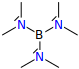

CN(B(N(C)C)N(C)C)C
Entry
Boron_Vuori
B(NMe2)3
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([216.44,269.495,315.6,355.658,420.551,469.4,546.443],'J/(mol*K)'), H298=(-239.6,'kJ/mol'), S298=(461,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(644.372,'J/(mol*K)'), E0=(-275.315,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([251.572,287.407,320.65,349.329,399.748,438.489,521.165],'J/(mol*K)'), H298=(-228.571,'kJ/mol'), S298=(612.872,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(N3s-Cs2B) + group(N3s-Cs2B) + group(N3s-Cs2B) + group(Cs-N3sHHH) + group(Cs-N3sHHH) + group(Cs-N3sHHH) + group(Cs-N3sHHH) + group(Cs-N3sHHH) + group(Cs-N3sHHH) + group(BCs3)""")

missing
['BR3_Bs-(CsCs)(CsCs)(CsCs)N3sN3sN3s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([236.559,271.83,304.65,333.047,383.325,422.489,505.165],'J/(mol*K)'), H298=(-244.571,'kJ/mol'), S298=(621.872,'J

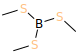

CSB(SC)SC
Entry
Boron_Vuori
B(SMe)3
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([153.426,181.094,203.2,221.366,249.494,270.1,302.55],'J/(mol*K)'), H298=(-199.1,'kJ/mol'), S298=(435.1,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(357.522,'J/(mol*K)'), E0=(-226.794,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([158.86,188.664,207.407,226.881,272.573,303.769,331.961],'J/(mol*K)'), H298=(-148.398,'kJ/mol'), S298=(596.864,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(S2s-BC) + group(S2s-BC) + group(S2s-BC) + group(Cs-S2sHHH) + group(Cs-S2sHHH) + group(Cs-S2sHHH) + group(BCs3)""")

missing
['BR3_Bs-(Cs)(Cs)(Cs)S2sS2sS2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([143.847,173.087,191.407,210.599,256.15,287.769,315.961],'J/(mol*K)'), H298=(-164.398,'kJ/mol'), S298=(605.864,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(S2s-BC) + g

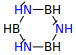

[nH]1[bH][nH][bH][nH][bH]1
Entry
Boron_Vuori
B3N3H6
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([87.6366,117.583,142.6,162.603,190.846,208.7,231.763],'J/(mol*K)'), H298=(-495.7,'kJ/mol'), S298=(287.8,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'), E0=(-510.185,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([15.2891,49.2711,82.4854,116.17,163.113,193.879,226.1],'J/(mol*K)'), H298=(281.923,'kJ/mol'), S298=(77.0975,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(N3s-CsCsCs) + group(N3s-CsCsCs) + group(N3s-CsCsCs) + group(BHCs2) + group(BHCs2) + group(BHCs2) + ring(Cyclohexane)""")

missing
['N3s_N3s-(N3sH)(N3sH)BsBsH', 'N3s_N3s-(N3sH)(N3sH)BsBsH', 'N3s_N3s-(N3sH)(N3sH)BsBsH', 'BHR2_Bs-(BsH)(BsH)N3sN3sH', 'BHR2_Bs-(BsH)(BsH)N3sN3sH', 'BHR2_Bs-(BsH)(BsH)N3sN3sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-24.2672,-17.1544,-12.1336

In [49]:
for spc_index in bad_fit_spc_index_list:
    check_data(index=spc_index)
    print("====")

# 4. Write fitted data to database

In [ ]:
database_new = deepcopy(database)
duplicate = dict()

for group_str in missing_group_dict.keys():
    group = missing_group_dict[group_str]["group"][0]
    group_atom = missing_group_dict[group_str]["atom"][0]
    molecule = missing_group_dict[group_str]["molecule"][0]
    entry_label = group_str.split("_")[-1]

    #Make sure there are no duplicate entry label
    if entry_label in database_new.groups['group'].entries:
        entry_data = database_new.groups['group'].entries[entry_label].data
        if entry_data is not None and not isinstance(entry_data,str):
            if not database_new.groups['group'].entries[entry_label].data.is_all_zeros():
                counter = 0
                while entry_label in database_new.groups['group'].entries:
                    print(entry_label)
                    if entry_label not in duplicate:
                        duplicate[entry_label] = dict()
                        duplicate[entry_label]["group"] = group
                        duplicate[entry_label]["atom"] = group_atom
                        duplicate[entry_label]["molecule"] = molecule
                    counter += 1
                    entry_label = entry_label.split('_')[0]
                    entry_label += '_{0}'.format(counter)
                    if entry_label not in duplicate:
                        duplicate[entry_label] = dict()
                        duplicate[entry_label]["group"] = group
                        duplicate[entry_label]["atom"] = group_atom
                        duplicate[entry_label]["molecule"] = molecule

    string = ''
    for ind in np.nonzero(A[:,missing_group_index_dict[group_str]])[0]:
        string += f'{all_data["entry"][ind].item.smiles} ({all_data["entry"][ind].label}) from {all_data["entry"][ind].short_desc}\n'

    node0 = database_new.groups['group'].descend_tree(molecule, {'*': group_atom}, None)

    # make L3 dummy node
    if node0.label in ["C", "O", "N", "S"]:
        entry = Entry(index = len(database_new.groups['group'].entries)+1,
                        label = group_atom.atomtype.label,
                        item = Group().from_adjacency_list(f"""1 * {group_atom.atomtype.label} u0"""),
                        data = None,
                        short_desc = """Dummy L3 group added by Hao-Wei Pang""",
                        long_desc = f"""Dummy L3 group added by Hao-Wei Pang during fitting groups from thermo libraries""",
                        parent = node0)
        database_new.groups["group"].entries[group_atom.atomtype.label] = entry
        database_new.groups["group"].entries[node0.label].children.append(entry)
        node0 = database_new.groups["group"].entries[group_atom.atomtype.label]

    replace = False
    reason = ''
    if node0.data is None:
        reason = "None"
    elif isinstance(node0.data,str):
        reason = node0.data
    elif node0.data.is_all_zeros():
        reason = "all zeros"

    if reason:
        #if node0 data is missing, and the new group is the same as the parent group,
        #then we replace the node0 data with the group data
        if node0.item.is_isomorphic(group):

            for atom in node0.item.atoms:
                if atom.label:
                    neighbors = ''.join(sorted([atom2.atomtype[0].label for atom2 in atom.edges.keys()
                                                if atom2.atomtype[0].label != 'H']))
                    neighbors += 'H' * len(['H' for atom2 in atom.edges.keys() if atom2.atomtype[0].label == 'H'])

                    node0_group_str = atom.atomtype[0].label

                    if neighbors:
                        node0_group_str += f'-{neighbors}'

                    if node0_group_str == entry_label:
                        replace = True

    missing_group_dict[group_str]["node0"] = node0

    if replace:
        #replace existing group entry
        database_new.groups['group'].entries[node0.label].data = fitted_group_data[group_str]
        database_new.groups['group'].entries[node0.label].short_desc = """Fitted from RMG thermo libraries by Hao-Wei Pang"""
        database_new.groups['group'].entries[node0.label].long_desc = f"""Previously contains {reason} as data. New data fitted from following species using Ridge regression

{string}

"""

        missing_group_dict[group_str]["entry"] = database_new.groups['group'].entries[node0.label]
        missing_group_dict[group_str]["replaced"] = True
    else:
        #make new group entry
        entry = Entry(index = len(database_new.groups['group'].entries)+1,
                        label = entry_label,
                        item = group,
                        data = fitted_group_data[group_str],
                        short_desc = """Group added & fitted from RMG thermo libraries by Hao-Wei Pang""",
                        long_desc = f"""Fitted from following species using Ridge regression

{string}

    """,
                         parent = node0)

        missing_group_dict[group_str]["entry"] = entry
        missing_group_dict[group_str]["replaced"] = False
        database_new.groups['group'].entries[entry_label] = entry
        database_new.groups["group"].entries[node0.label].children.append(entry)

        ################################ test #######################################
        #test that we can make sample molecule
        #test that the sample molecuke descend to itself or its ancestors
        #test that node0 is an appropriate parent for its child entry
        try:
            sample_molecule = entry.item.make_sample_molecule()
        except:
            logging.error("Problem making sample molecule for group {}\n{}".format(
                entryName, entry.item.to_adjacency_list()))
            raise
        # for now ignore sample atoms that use nitrogen types
        nitrogen = False
        for atm in sample_molecule.atoms:
            if atm.is_nitrogen():
                nitrogen = True

        if not nitrogen:
            atoms = sample_molecule.get_all_labeled_atoms()
            match = database_new.groups["group"].descend_tree(sample_molecule, atoms, strict=True)

            if entry not in [match] + database_new.groups["group"].ancestors(match):
                raise

        if not database_new.groups["group"].match_node_to_child(node0, entry):
            raise

# 5. Check that we land on the right node when using the new database

## 5.1 Estimate thermo using the new database

In [ ]:
all_data["New GAE"] = list()
for entry in all_data["entry"]:
    molecule = entry.item
    all_data["New GAE"].append(database_new.estimate_thermo_via_group_additivity(molecule))

## 5.2 Parity plot for the library entry vs. new estimation

In [ ]:
colormap = mpl.cm.tab20
plt.figure(figsize=(10,10))
entry_values = list()
old_GAE_values = list()
new_GAE_values = list()
new_GAE_uncertainties = list()
new_new_GAE_values = list()

for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_values.append(entry_thermo.H298.value_si/4180)
    estimated_GAE = all_data["GAE with estimated GAV"][spc_index]
    old_GAE_values.append(estimated_GAE.H298.value_si/4180)
    fitted_GAE = all_data["GAE with fitted GAV"][spc_index]
    new_GAE_values.append(fitted_GAE.H298.value_si/4180)
    new_GAE_uncertainties.append(fitted_GAE.H298.uncertainty_si/4180)
    new_new_GAE_values.append(all_data["New GAE"][spc_index].H298.value_si/4180)


plt.figure(figsize=(10,10))
plt.errorbar(entry_values,old_GAE_values,fmt='o')
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
RMSE = mean_squared_error(entry_values,old_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,old_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} kcal/mol')
plt.xlabel("H298: Entry data (kcal/mol)")
plt.ylabel("H298: Old estimation (kcal/mol)")

plt.figure(figsize=(10,10))
plt.errorbar(x=entry_values,y=new_GAE_values,yerr=new_GAE_uncertainties,fmt='o')
for i, entry_value in enumerate(entry_values):
    if abs(entry_value - new_GAE_values[i])>15:
        plt.text(entry_value, new_GAE_values[i], s=all_data["entry"][i].label)
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
plt.xlabel("H298: Entry data (kcal/mol)")
plt.ylabel("H298: New estimation with fitted data (kcal/mol)")
RMSE = mean_squared_error(entry_values,new_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,new_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} kcal/mol')

In [ ]:
colormap = mpl.cm.tab20
plt.figure(figsize=(10,10))
entry_values = list()
old_GAE_values = list()
new_GAE_values = list()
new_GAE_uncertainties = list()
new_new_GAE_values = list()


for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_values.append(entry_thermo.S298.value_si/4.180)
    estimated_GAE = all_data["GAE with estimated GAV"][spc_index]
    old_GAE_values.append(estimated_GAE.S298.value_si/4.180)
    fitted_GAE = all_data["GAE with fitted GAV"][spc_index]
    new_GAE_values.append(fitted_GAE.S298.value_si/4.180)
    new_GAE_uncertainties.append(fitted_GAE.S298.uncertainty_si/4.180)
    new_new_GAE_values.append(all_data["New GAE"][spc_index].S298.value_si/4.180)

plt.figure(figsize=(10,10))
plt.errorbar(entry_values,old_GAE_values,fmt='o')
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
RMSE = mean_squared_error(entry_values,old_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,old_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} cal/(mol*K)')
plt.xlabel("S298: Entry data (cal/(mol*K))")
plt.ylabel("S298: Old estimation (cal/(mol*K))")

plt.figure(figsize=(10,10))
plt.errorbar(x=entry_values,y=new_GAE_values,yerr=new_GAE_uncertainties,fmt='o')
for i, entry_value in enumerate(entry_values):
    if abs(entry_value - new_GAE_values[i])>3:
        plt.text(entry_value, new_GAE_values[i], s=all_data["entry"][i].label)
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
plt.xlabel("S298: Entry data (cal/(mol*K))")
plt.ylabel("S298: New estimation with fitted data (cal/(mol*K))")
RMSE = mean_squared_error(entry_values,new_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,new_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} cal/(mol*K)')

# 6. Make sure we pass database test

In [ ]:
group_name = "group"
group = database.groups["group"]

entries_copy = copy(group.entries)
tst = []
for node_name, node_group in group.entries.items():
    del entries_copy[node_name]
    for node_name_other, node_group_other in entries_copy.items():
        group.match_node_to_node(node_group, node_group_other)
        tst.append((group.match_node_to_node(node_group, node_group_other),
                    "Node {node} in {group} group was found to be identical to node {node_other}".format(
                        node=node_name, group=group_name, node_other=node_name_other)))

boo = False
for i in range(len(tst)):
    if tst[i][0]:
        logging.error(tst[i][1])
        boo = True

if boo:
    raise ValueError("Error Occurred")



In [ ]:
tst1 = []
tst2 = []
for node_name, child_node in group.entries.items():
    # top nodes and product nodes don't have parents by definition, so they get an automatic pass:
    if child_node in group.top:
        continue
    parent_node = child_node.parent
    # Check whether the node has proper parents unless it is the top reactant or product node
    # The parent should be more general than the child
    tst1.append((group.match_node_to_child(parent_node, child_node),
                 "In {group} group, node {parent} is not a proper parent of its child {child}.".format(
                     group=group_name, parent=parent_node, child=node_name)))

    # check that parentNodes which are LogicOr do not have an ancestor that is a Group
    # If it does, then the child_node must also be a child of the ancestor
    if isinstance(parent_node.item, LogicOr):
        ancestor_node = parent_node
        while ancestor_node not in group.top and isinstance(ancestor_node.item, LogicOr):
            ancestor_node = ancestor_node.parent
        if isinstance(ancestor_node.item, Group) and tst1[-1][0]:
            tst2.append((group.match_node_to_child(ancestor_node, child_node),
                         "In {group} group, node {ancestor} is not a proper ancestor of its child {child}."
                         "".format(group=group_name, ancestor=ancestor_node, child=node_name)))

boo = False
for i in range(len(tst1)):
    if not tst1[i][0]:
        logging.error(tst1[i][1])
        boo = True
for i in range(len(tst2)):
    if not tst2[i][0]:
        logging.error(tst2[i][1])
        boo = True

if boo:
    raise ValueError("Error Occurred")

# Save new database to file

In [ ]:
database_new.groups["group"].save(os.path.join(settings["database.directory"],"thermo/groups/group.py"))